# Emotion Architecture in Reddit Comments  
## A Diagnostic and Predictive Exploration of Crowdsourced Emotional Labels


### Stakeholder Focus

This project is designed for:

- **Emotion AI Strategists**: building systems that detect and respond to emotional signals.
- **Annotation Auditors & Dataset Curators**: improving labeling quality in NLP datasets.
- **Language Intelligence Researchers**:studying the structure and reliability of emotion-labeled data.

The focus is not just emotion detection, but emotional **structure**, **inconsistency**, and **interpretability failure** in one of the most widely-used English emotion datasets.


### Research Questions

1. **How consistent are emotional labels across raters in the GoEmotions dataset?**
2. **Can we detect and filter low-quality annotators to rebuild trust in the dataset?**
3. **How do emotions relate to each other i.e. co-occurrence, contradiction, or isolation?**
4. **Do subreddit communities exhibit unique emotional fingerprints?**
5. **Can emotional signals in text contradict the assigned labels and how often?**
6. **How well can a basic ML model predict emotional labels and what are its limits?**


### Project Structure:
- ROUND 1: Dataset Cleaning & Emotion Frequency
- ROUND 2: Trust Filtering, Subreddit Profiling
- ROUND 3: Language Signal, Prediction
- Appendix: Rater Profiling
- Mystery Bonus

This project explores Reddit’s emotional terrain using the GoEmotions dataset. From the lens of Emotion AI strategists and annotation auditors, I investigated patterns in human-labeled emotional data, with a focus on inconsistency, latent emotional topology, and interpretability failures.

What began as a student EDA evolved into a broader exploration of emotional data and the tools used to analyze it.
Driven by curiosity more than formal hypothesis, I experimented with Word2Vec, t-SNE projections, annotator comparisons, and co-occurrence mappings — not just to find answers, but to understand how different methods shape what we see in emotional language.

In [1]:
# Libraries for analysis and visualization

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import random
import gensim
import os

# Freeze for final reproducible plot
FINAL_SEED = 16
random.seed(FINAL_SEED)
np.random.seed(FINAL_SEED)
os.environ['PYTHONHASHSEED'] = str(FINAL_SEED)


# Later use
from itertools import combinations
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from gensim.models import Word2Vec
gensim.models.word2vec.FAST_VERSION = 0  # Force Python version for full reproducibility


# Load dataset
df = pd.read_csv("/kaggle/input/goemotions/GoEmotions.csv")
print("Shape: ", df.shape)

Shape:  (211225, 37)


## 🥐 ROUND 1: Dataset Structure and Labeling Foundation

We begin by scanning dataset shape, rater behavior, and basic emotion frequency.  
This establishes how emotions are labeled, how raters behave, and how much “neutral” dominates.

### Goals:
- Validate structure
- Clean and group per-comment dataset
- Understand initial label noise

FOR WHAT? → General shape, completeness, types, distribution, uniqueness.

SO WHAT? → Provides with schema literacy and shows stakeholder how clean the data is.

In [2]:
# Sample rows
display(df.head())
display(df.tail())

text       id  \
0                                    That game hurt.  eew5j0j   
1   >sexuality shouldn’t be a grouping category I...  eemcysk   
2     You do right, if you don't care then fuck 'em!  ed2mah1   
3                                 Man I love reddit.  eeibobj   
4  [NAME] was nowhere near them, he was by the Fa...  eda6yn6   

                author            subreddit    link_id   parent_id  \
0                Brdd9                  nrl  t3_ajis4z  t1_eew18eq   
1          TheGreen888     unpopularopinion  t3_ai4q37   t3_ai4q37   
2             Labalool          confessions  t3_abru74  t1_ed2m7g7   
3        MrsRobertshaw             facepalm  t3_ahulml   t3_ahulml   
4  American_Fascist713  starwarsspeculation  t3_ackt2f  t1_eda65q2   

    created_utc  rater_id  example_very_unclear  admiration  ...  love  \
0  1.548381e+09         1                 False           0  ...     0   
1  1.548084e+09        37                  True           0  ...     0   
2  1.546428e+09        37                 False           0  ...     0   
3  1.547965e+09        18                 False           0  ...     1   
4  1.546669e+09         2                 False           0  ...     0   

   nervousness  optimism  pride  realization  relief  remorse  sadness  \
0            0         0      0            0       0        0        1   
1            0         0      0            0       0        0        0   
2            0         0      0            0       0        0        0   
3            0         0      0            0       0        0        0   
4            0         0      0            0       0        0        0   

   surprise  neutral  
0         0        0  
1         0        0  
2         0        1  
3         0        0  
4         0        1  

[5 rows x 37 columns]

text       id  \
211220                             Everyone likes [NAME].  ee6pagw   
211221  Well when you’ve imported about a gazillion of...  ef28nod   
211222                                 That looks amazing  ee8hse1   
211223  The FDA has plenty to criticize. But like here...  edrhoxh   
211224  Desktop link: ^^/r/HelperBot_ ^^Downvote ^^to ...  edze9g4   

            author         subreddit    link_id   parent_id   created_utc  \
211220    Senshado  heroesofthestorm  t3_agjf24   t3_agjf24  1.547634e+09   
211221  5inchloser       nottheonion  t3_ak26t3   t3_ak26t3  1.548553e+09   
211222  springt1me    shittyfoodporn  t3_agrnqb   t3_agrnqb  1.547684e+09   
211223   enamedata          medicine  t3_aejqzd  t1_edrgdtx  1.547169e+09   
211224  HelperBot_     MorbidReality  t3_afhw30  t1_edze91s  1.547397e+09   

        rater_id  example_very_unclear  admiration  ...  love  nervousness  \
211220        16                 False           0  ...     1            0   
211221        15                 False           0  ...     0            0   
211222        70                 False           1  ...     0            0   
211223         4                 False           0  ...     0            0   
211224        61                  True           0  ...     0            0   

        optimism  pride  realization  relief  remorse  sadness  surprise  \
211220         0      0            0       0        0        0         0   
211221         0      0            0       0        0        0         0   
211222         0      0            0       0        0        0         0   
211223         0      0            0       0        0        0         0   
211224         0      0            0       0        0        0         0   

        neutral  
211220        0  
211221        0  
211222        0  
211223        0  
211224        0  

[5 rows x 37 columns]

In [3]:
# Structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211225 entries, 0 to 211224
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   text                  211225 non-null  object 
 1   id                    211225 non-null  object 
 2   author                211225 non-null  object 
 3   subreddit             211225 non-null  object 
 4   link_id               211225 non-null  object 
 5   parent_id             211225 non-null  object 
 6   created_utc           211225 non-null  float64
 7   rater_id              211225 non-null  int64  
 8   example_very_unclear  211225 non-null  bool   
 9   admiration            211225 non-null  int64  
 10  amusement             211225 non-null  int64  
 11  anger                 211225 non-null  int64  
 12  annoyance             211225 non-null  int64  
 13  approval              211225 non-null  int64  
 14  caring                211225 non-null  int64  
 15  

In [4]:
# Missing values
print(df.isnull().sum())

text                    0
id                      0
author                  0
subreddit               0
link_id                 0
parent_id               0
created_utc             0
rater_id                0
example_very_unclear    0
admiration              0
amusement               0
anger                   0
annoyance               0
approval                0
caring                  0
confusion               0
curiosity               0
desire                  0
disappointment          0
disapproval             0
disgust                 0
embarrassment           0
excitement              0
fear                    0
gratitude               0
grief                   0
joy                     0
love                    0
nervousness             0
optimism                0
pride                   0
realization             0
relief                  0
remorse                 0
sadness                 0
surprise                0
neutral                 0
dtype: int64


In [5]:
# Summary statistics
display(df.describe())

created_utc       rater_id     admiration      amusement  \
count  2.112250e+05  211225.000000  211225.000000  211225.000000   
mean   1.547659e+09      37.619742       0.081103       0.043768   
std    7.696842e+05      23.070528       0.272994       0.204580   
min    1.546301e+09       0.000000       0.000000       0.000000   
25%    1.546993e+09      19.000000       0.000000       0.000000   
50%    1.547664e+09      37.000000       0.000000       0.000000   
75%    1.548320e+09      57.000000       0.000000       0.000000   
max    1.548979e+09      81.000000       1.000000       1.000000   

               anger      annoyance       approval         caring  \
count  211225.000000  211225.000000  211225.000000  211225.000000   
mean        0.038272       0.064472       0.083418       0.028401   
std         0.191853       0.245592       0.276514       0.166116   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

           confusion      curiosity  ...           love    nervousness  \
count  211225.000000  211225.000000  ...  211225.000000  211225.000000   
mean        0.034840       0.045885  ...       0.038779       0.008569   
std         0.183374       0.209236  ...       0.193067       0.092172   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.000000       0.000000  ...       0.000000       0.000000   
50%         0.000000       0.000000  ...       0.000000       0.000000   
75%         0.000000       0.000000  ...       0.000000       0.000000   
max         1.000000       1.000000  ...       1.000000       1.000000   

            optimism          pride    realization         relief  \
count  211225.000000  211225.000000  211225.000000  211225.000000   
mean        0.041259       0.006164       0.041591       0.006102   
std         0.198890       0.078269       0.199653       0.077880   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

             remorse        sadness       surprise        neutral  
count  211225.000000  211225.000000  211225.000000  211225.000000  
mean        0.011954       0.031994       0.026105       0.261797  
std         0.108679       0.175985       0.159448       0.439614  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000       1.000000  
max         1.000000       1.000000       1.000000       1.000000  

[8 rows x 30 columns]

In [6]:
# Column types and counts
print("Column names:\n", df.columns.tolist())

Column names:
 ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [7]:
# Unique value counts 
print(df.nunique())

text                    57732
id                      58011
author                  49178
subreddit                 483
link_id                 44897
parent_id               54924
created_utc             57257
rater_id                   82
example_very_unclear        2
admiration                  2
amusement                   2
anger                       2
annoyance                   2
approval                    2
caring                      2
confusion                   2
curiosity                   2
desire                      2
disappointment              2
disapproval                 2
disgust                     2
embarrassment               2
excitement                  2
fear                        2
gratitude                   2
grief                       2
joy                         2
love                        2
nervousness                 2
optimism                    2
pride                       2
realization                 2
relief                      2
remorse   

## Datetime Conversion

FOR WHAT? → Enabling temporal analysis {possible later use}

SO WHAT? → Allows filtering, trends, subreddit-timing breakdowns

In [8]:
# Convert UNIX timestamp to readable datetime
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s', errors='coerce')

# Create helper fields (optional but futureproof)
df['year'] = df['created_utc'].dt.year
df['month'] = df['created_utc'].dt.month
df['day'] = df['created_utc'].dt.day

df

text       id  \
0                                         That game hurt.  eew5j0j   
1        >sexuality shouldn’t be a grouping category I...  eemcysk   
2          You do right, if you don't care then fuck 'em!  ed2mah1   
3                                      Man I love reddit.  eeibobj   
4       [NAME] was nowhere near them, he was by the Fa...  eda6yn6   
...                                                   ...      ...   
211220                             Everyone likes [NAME].  ee6pagw   
211221  Well when you’ve imported about a gazillion of...  ef28nod   
211222                                 That looks amazing  ee8hse1   
211223  The FDA has plenty to criticize. But like here...  edrhoxh   
211224  Desktop link: ^^/r/HelperBot_ ^^Downvote ^^to ...  edze9g4   

                     author            subreddit    link_id   parent_id  \
0                     Brdd9                  nrl  t3_ajis4z  t1_eew18eq   
1               TheGreen888     unpopularopinion  t3_ai4q37   t3_ai4q37   
2                  Labalool          confessions  t3_abru74  t1_ed2m7g7   
3             MrsRobertshaw             facepalm  t3_ahulml   t3_ahulml   
4       American_Fascist713  starwarsspeculation  t3_ackt2f  t1_eda65q2   
...                     ...                  ...        ...         ...   
211220             Senshado     heroesofthestorm  t3_agjf24   t3_agjf24   
211221           5inchloser          nottheonion  t3_ak26t3   t3_ak26t3   
211222           springt1me       shittyfoodporn  t3_agrnqb   t3_agrnqb   
211223            enamedata             medicine  t3_aejqzd  t1_edrgdtx   
211224           HelperBot_        MorbidReality  t3_afhw30  t1_edze91s   

               created_utc  rater_id  example_very_unclear  admiration  ...  \
0      2019-01-25 01:50:39         1                 False           0  ...   
1      2019-01-21 15:22:49        37                  True           0  ...   
2      2019-01-02 11:15:44        37                 False           0  ...   
3      2019-01-20 06:17:34        18                 False           0  ...   
4      2019-01-05 06:10:01         2                 False           0  ...   
...                    ...       ...                   ...         ...  ...   
211220 2019-01-16 10:25:22        16                 False           0  ...   
211221 2019-01-27 01:39:42        15                 False           0  ...   
211222 2019-01-17 00:08:54        70                 False           1  ...   
211223 2019-01-11 01:07:12         4                 False           0  ...   
211224 2019-01-13 16:34:22        61                  True           0  ...   

        pride  realization  relief  remorse  sadness  surprise  neutral  year  \
0           0            0       0        0        1         0        0  2019   
1           0            0       0        0        0         0        0  2019   
2           0            0       0        0        0         0        1  2019   
3           0            0       0        0        0         0        0  2019   
4           0            0       0        0        0         0        1  2019   
...       ...          ...     ...      ...      ...       ...      ...   ...   
211220      0            0       0        0        0         0        0  2019   
211221      0            0       0        0        0         0        0  2019   
211222      0            0       0        0        0         0        0  2019   
211223      0            0       0        0        0         0        0  2019   
211224      0            0       0        0        0         0        0  2019   

        month  day  
0           1   25  
1           1   21  
2           1    2  
3           1   20  
4           1    5  
...       ...  ...  
211220      1   16  
211221      1   27  
211222      1   17  
211223      1   11  
211224      1   13  

[211225 rows x 40 columns]

## Emotion Columns Definition

FOR WHAT? → Extract the 28 binary emotion columns

SO WHAT? → Central to all further logic, filtering, aggregation

In [9]:
# Define emotion label columns (from 'admiration' to 'neutral', inclusive)
emotion_cols = df.loc[:, 'admiration':'neutral'].columns.tolist()

print(f"{len(emotion_cols)} emotion columns loaded.")

28 emotion columns loaded.


## Total Frequency of Emotion Labels given (raw)

FOR WHAT? → Shows how often each emotion was assigned (not per comment, but across all raters, i.e. clicks).

SO WHAT? → Stakeholders see labeling imbalance or common patterns like dominance of neutral,

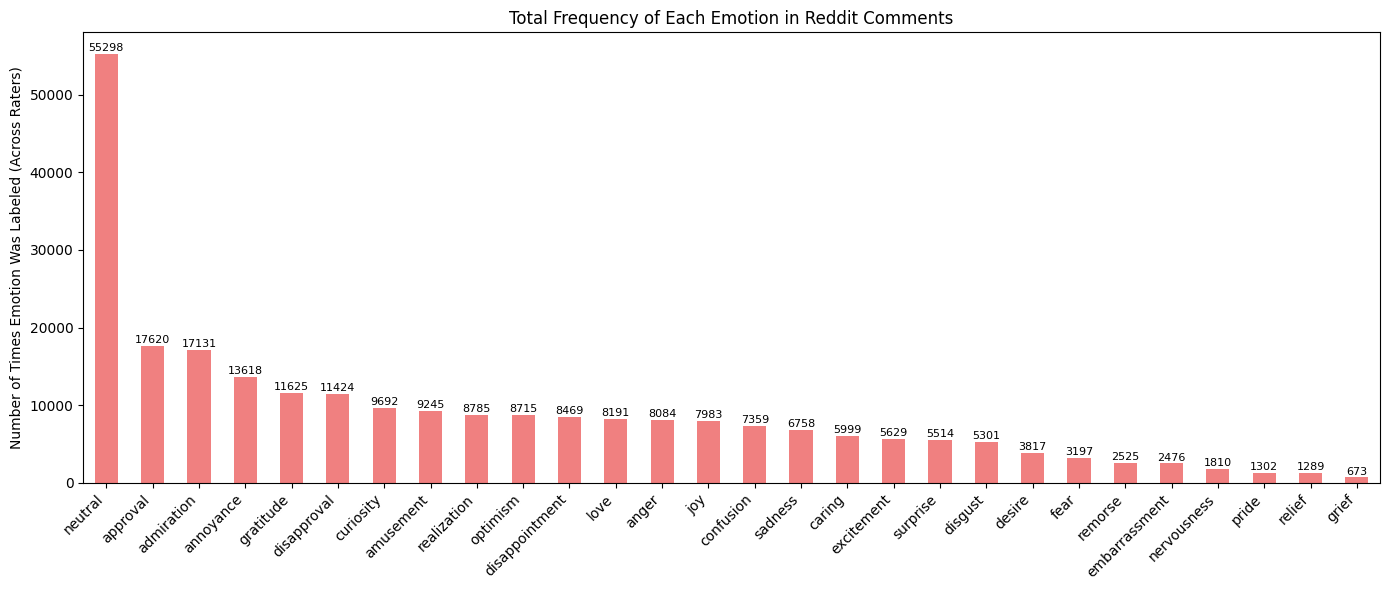

In [10]:
# Emotion Label Frequency (raw count across raters)
emotion_counts = df[emotion_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(14,6))
ax = emotion_counts.plot(kind='bar', color='lightcoral')
for i, v in enumerate(emotion_counts):
    ax.text(i, v + 100, str(int(v)), ha='center', va='bottom', fontsize=8)
plt.title('Total Frequency of Each Emotion in Reddit Comments')
plt.ylabel('Number of Times Emotion Was Labeled (Across Raters)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Rater Behavior Analysis

FOR WHAT? → Detects raters who overuse “neutral”

SO WHAT? → Quality control signal. May indicate subjectivity or laziness.

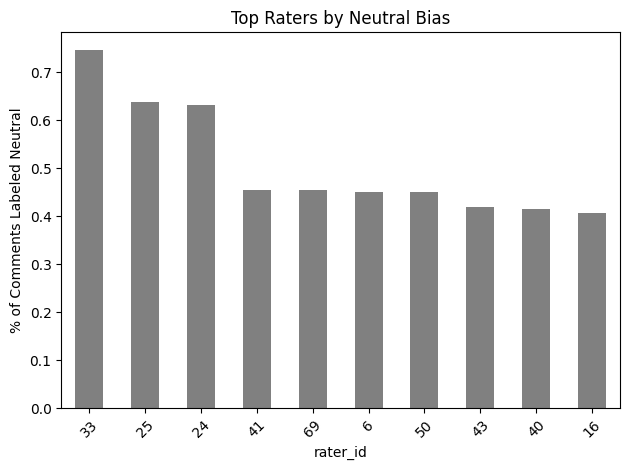

In [11]:
# Neutral Overuse
top_raters = df.groupby('rater_id')['neutral'].mean().sort_values(ascending=False).head(10)

top_raters.plot(kind='bar', color='gray')
plt.title('Top Raters by Neutral Bias')
plt.ylabel('% of Comments Labeled Neutral')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Emotion Distribution Per Rater

FOR WHAT? → Show how individual raters vary across emotions.

SO WHAT? → Underlines inter-rater variability → relevant for weighting or downstream trust metrics.

In [12]:
# Average per-emotion labeling per rater
df.groupby('rater_id')[emotion_cols].mean().sort_values(by='neutral', ascending=False)

admiration  amusement     anger  annoyance  approval    caring  \
rater_id                                                                   
33          0.040075   0.004687  0.003750   0.007734  0.000937  0.000000   
25          0.037940   0.013550  0.021680   0.029810  0.059621  0.010840   
24          0.085268   0.023221  0.020063   0.025822  0.009660  0.002601   
41          0.034269   0.014864  0.013212   0.138728  0.073080  0.018167   
69          0.072727   0.054545  0.009091   0.036364  0.009091  0.009091   
...              ...        ...       ...        ...       ...       ...   
79          0.137890   0.027578  0.051559   0.161871  0.161871  0.064748   
11          0.031234   0.035330  0.067076   0.109063  0.011777  0.052227   
66          0.096762   0.038551  0.040864   0.210486  0.150732  0.024287   
65          0.107143   0.042857  0.028571   0.092857  0.157143  0.028571   
68          0.000000   0.000000  0.000000   1.000000  0.000000  0.000000   

          confusion  curiosity    desire  disappointment  ...      love  \
rater_id                                                  ...             
33         0.000703   0.001640  0.000000        0.001172  ...  0.050387   
25         0.008130   0.000000  0.002710        0.032520  ...  0.005420   
24         0.006316   0.003715  0.000557        0.009474  ...  0.031209   
41         0.050372   0.010735  0.007845        0.005780  ...  0.026012   
69         0.000000   0.009091  0.036364        0.136364  ...  0.018182   
...             ...        ...       ...             ...  ...       ...   
79         0.069544   0.043165  0.046763        0.197842  ...  0.026379   
11         0.037378   0.048131  0.010753        0.074757  ...  0.022017   
66         0.067849   0.127217  0.027756        0.142251  ...  0.013878   
65         0.050000   0.121429  0.028571        0.078571  ...  0.014286   
68         0.000000   0.000000  0.000000        0.000000  ...  0.000000   

          nervousness  optimism     pride  realization    relief   remorse  \
rater_id                                                                     
33           0.000937  0.001640  0.001172     0.000937  0.000234  0.000703   
25           0.002710  0.008130  0.000000     0.024390  0.000000  0.005420   
24           0.001486  0.015976  0.004830     0.002787  0.000557  0.000186   
41           0.003303  0.015690  0.001652     0.013625  0.004129  0.005780   
69           0.009091  0.027273  0.000000     0.009091  0.009091  0.000000   
...               ...       ...       ...          ...       ...       ...   
79           0.004796  0.079137  0.014388     0.153477  0.013189  0.004796   
11           0.017409  0.077317  0.003072     0.030210  0.001024  0.036866   
66           0.002313  0.127988  0.009638     0.077101  0.008867  0.015420   
65           0.000000  0.035714  0.007143     0.035714  0.007143  0.014286   
68           0.000000  0.000000  0.000000     0.000000  0.000000  0.000000   

           sadness  surprise   neutral  
rater_id                                
33        0.009609  0.003750  0.745723  
25        0.016260  0.016260  0.636856  
24        0.008360  0.008174  0.632361  
41        0.018167  0.014038  0.455409  
69        0.027273  0.000000  0.454545  
...            ...       ...       ...  
79        0.041966  0.014388  0.026379  
11        0.024578  0.027138  0.024578  
66        0.027756  0.014649  0.018119  
65        0.014286  0.014286  0.007143  
68        0.000000  0.000000  0.000000  

[82 rows x 28 columns]

## Neutral Prevalence (per unique comment)

FOR WHAT? → Whether each comment got at least one “neutral” tag

SO WHAT? → Insight into dataset skew — is neutral a fallback?

In [13]:
neutral_flags = df.groupby('id')['neutral'].max()
neutral_percent = neutral_flags.sum() / df['id'].nunique() * 100
print(f"Neutral was marked in {neutral_percent:.2f}% of all unique comments")

Neutral was marked in 54.34% of all unique comments


## ! df_clean
## Create Cleaned Dataset df_clean, grouped by Comment ID (Final Emotion Scores per Comment)
### Core DataFrame for meaningful, per-comment analysis, not per rater

FOR WHAT?

df_grouped: Mean emotion score per comment

df_meta: Preserve original text/subreddit info

df_clean: Final usable dataset

SO WHAT?
Core DataFrame for meaningful, per-comment analysis → not per rater.

In [14]:
# Average emotion values per comment
df_grouped = df.groupby('id')[emotion_cols].mean()

# Get non-emotion fields: just one per comment
meta_cols = ['text', 'subreddit', 'created_utc']
df_meta = df.groupby('id')[meta_cols].first()

# Merge into final clean DataFrame
df_clean = pd.concat([df_meta, df_grouped], axis=1).reset_index()

df_clean

id                                               text  \
0      eczazk6  Fast as [NAME] will carry me. Seriously uptown...   
1      eczb07q        You blew it. They played you like a fiddle.   
2      eczb4bm  TL;DR No more Superbowls for [NAME]. Get ready...   
3      eczb527                           So much time saved. Not.   
4      eczb6r7  Emotes have a ridiculous amount of effort put ...   
...        ...                                                ...   
58006  efhclgb  [NAME]. I’m not sure you’ll feel the same way ...   
58007  efhcm78    I can see why! I would totally be offended too!   
58008  efhcnhz  Approaching doesn't work unless you are [NAME]...   
58009  efhcreo                                    Hahaha perfect.   
58010  efhcuxi                              Ok now that was epic!   

               subreddit         created_utc  admiration  amusement  anger  \
0             NewOrleans 2019-01-01 00:00:19    0.000000   0.000000    0.0   
1                   self 2019-01-01 00:00:34    0.000000   0.000000    0.0   
2               steelers 2019-01-01 00:02:14    0.000000   0.000000    0.0   
3                Roadcam 2019-01-01 00:02:32    0.000000   0.000000    0.0   
4              Blackops4 2019-01-01 00:03:14    0.000000   0.000000    0.0   
...                  ...                 ...         ...        ...    ...   
58006       bodybuilding 2019-01-31 23:53:59    0.000000   0.000000    0.0   
58007       greysanatomy 2019-01-31 23:54:24    0.000000   0.000000    0.0   
58008       ForeverAlone 2019-01-31 23:55:22    0.000000   0.000000    0.0   
58009  CollegeBasketball 2019-01-31 23:57:48    0.666667   0.333333    0.0   
58010        PUBGXboxOne 2019-01-31 23:59:36    0.333333   0.000000    0.0   

       annoyance  approval  caring  ...  love  nervousness  optimism  pride  \
0            0.0       1.0     0.0  ...   0.0          0.0       0.0    0.0   
1            0.0       0.0     0.0  ...   0.0          0.0       0.0    0.0   
2            0.0       0.0     0.0  ...   0.0          0.0       0.0    0.0   
3            0.0       0.0     0.0  ...   0.0          0.0       0.0    0.0   
4            0.0       0.2     0.0  ...   0.0          0.0       0.0    0.0   
...          ...       ...     ...  ...   ...          ...       ...    ...   
58006        0.0       0.0     0.0  ...   0.0          0.0       0.0    0.0   
58007        0.4       0.2     0.0  ...   0.0          0.0       0.0    0.0   
58008        0.0       0.0     0.0  ...   0.0          0.0       0.0    0.0   
58009        0.0       0.0     0.0  ...   0.0          0.0       0.0    0.0   
58010        0.0       0.0     0.0  ...   0.0          0.0       0.0    0.0   

       realization  relief  remorse  sadness  surprise   neutral  
0              0.0     0.0      0.0      0.0       0.0  0.000000  
1              0.0     0.0      0.0      0.0       0.0  1.000000  
2              0.0     0.0      0.0      0.0       0.0  0.000000  
3              0.0     0.0      0.0      0.0       0.0  0.000000  
4              0.2     0.0      0.0      0.2       0.0  0.400000  
...            ...     ...      ...      ...       ...       ...  
58006          0.0     0.0      0.0      0.0       0.0  0.000000  
58007          0.2     0.0      0.0      0.2       0.0  0.000000  
58008          0.0     0.0      0.0      0.0       0.0  1.000000  
58009          0.0     0.0      0.0      0.0       0.0  0.000000  
58010          0.0     0.0      0.0      0.0       0.0  0.666667  

[58011 rows x 32 columns]

## Rater Count Merge

FOR WHAT? → Adds a field showing how many raters labeled each comment

SO WHAT? → Adds trust/weight signal for multi-label confidence

In [15]:
df['id'].value_counts()

id
eew5j0j    5
eeem310    5
ed9km8y    5
ed1djsl    5
ee8wvo4    5
          ..
ee0v8a8    1
eerolx8    1
ed7via6    1
eellksw    1
edcp8f5    1
Name: count, Length: 58011, dtype: int64

In [16]:
rater_counts = df['id'].value_counts().rename('rater_count')
df_clean = df_clean.merge(rater_counts, left_on='id', right_index=True)
df_clean

id                                               text  \
0      eczazk6  Fast as [NAME] will carry me. Seriously uptown...   
1      eczb07q        You blew it. They played you like a fiddle.   
2      eczb4bm  TL;DR No more Superbowls for [NAME]. Get ready...   
3      eczb527                           So much time saved. Not.   
4      eczb6r7  Emotes have a ridiculous amount of effort put ...   
...        ...                                                ...   
58006  efhclgb  [NAME]. I’m not sure you’ll feel the same way ...   
58007  efhcm78    I can see why! I would totally be offended too!   
58008  efhcnhz  Approaching doesn't work unless you are [NAME]...   
58009  efhcreo                                    Hahaha perfect.   
58010  efhcuxi                              Ok now that was epic!   

               subreddit         created_utc  admiration  amusement  anger  \
0             NewOrleans 2019-01-01 00:00:19    0.000000   0.000000    0.0   
1                   self 2019-01-01 00:00:34    0.000000   0.000000    0.0   
2               steelers 2019-01-01 00:02:14    0.000000   0.000000    0.0   
3                Roadcam 2019-01-01 00:02:32    0.000000   0.000000    0.0   
4              Blackops4 2019-01-01 00:03:14    0.000000   0.000000    0.0   
...                  ...                 ...         ...        ...    ...   
58006       bodybuilding 2019-01-31 23:53:59    0.000000   0.000000    0.0   
58007       greysanatomy 2019-01-31 23:54:24    0.000000   0.000000    0.0   
58008       ForeverAlone 2019-01-31 23:55:22    0.000000   0.000000    0.0   
58009  CollegeBasketball 2019-01-31 23:57:48    0.666667   0.333333    0.0   
58010        PUBGXboxOne 2019-01-31 23:59:36    0.333333   0.000000    0.0   

       annoyance  approval  caring  ...  nervousness  optimism  pride  \
0            0.0       1.0     0.0  ...          0.0       0.0    0.0   
1            0.0       0.0     0.0  ...          0.0       0.0    0.0   
2            0.0       0.0     0.0  ...          0.0       0.0    0.0   
3            0.0       0.0     0.0  ...          0.0       0.0    0.0   
4            0.0       0.2     0.0  ...          0.0       0.0    0.0   
...          ...       ...     ...  ...          ...       ...    ...   
58006        0.0       0.0     0.0  ...          0.0       0.0    0.0   
58007        0.4       0.2     0.0  ...          0.0       0.0    0.0   
58008        0.0       0.0     0.0  ...          0.0       0.0    0.0   
58009        0.0       0.0     0.0  ...          0.0       0.0    0.0   
58010        0.0       0.0     0.0  ...          0.0       0.0    0.0   

       realization  relief  remorse  sadness  surprise   neutral  rater_count  
0              0.0     0.0      0.0      0.0       0.0  0.000000            2  
1              0.0     0.0      0.0      0.0       0.0  1.000000            2  
2              0.0     0.0      0.0      0.0       0.0  0.000000            3  
3              0.0     0.0      0.0      0.0       0.0  0.000000            3  
4              0.2     0.0      0.0      0.2       0.0  0.400000            5  
...            ...     ...      ...      ...       ...       ...          ...  
58006          0.0     0.0      0.0      0.0       0.0  0.000000            3  
58007          0.2     0.0      0.0      0.2       0.0  0.000000            5  
58008          0.0     0.0      0.0      0.0       0.0  1.000000            3  
58009          0.0     0.0      0.0      0.0       0.0  0.000000            3  
58010          0.0     0.0      0.0      0.0       0.0  0.666667            3  

[58011 rows x 33 columns]

## Visualize Emotion Mean per Comment (not raw counts)

FOR WHAT? → More accurate than raw count; this is **normalized**

SO WHAT? → Gives final picture of emotion prevalence **in grouped data**

<function matplotlib.pyplot.show(close=None, block=None)>

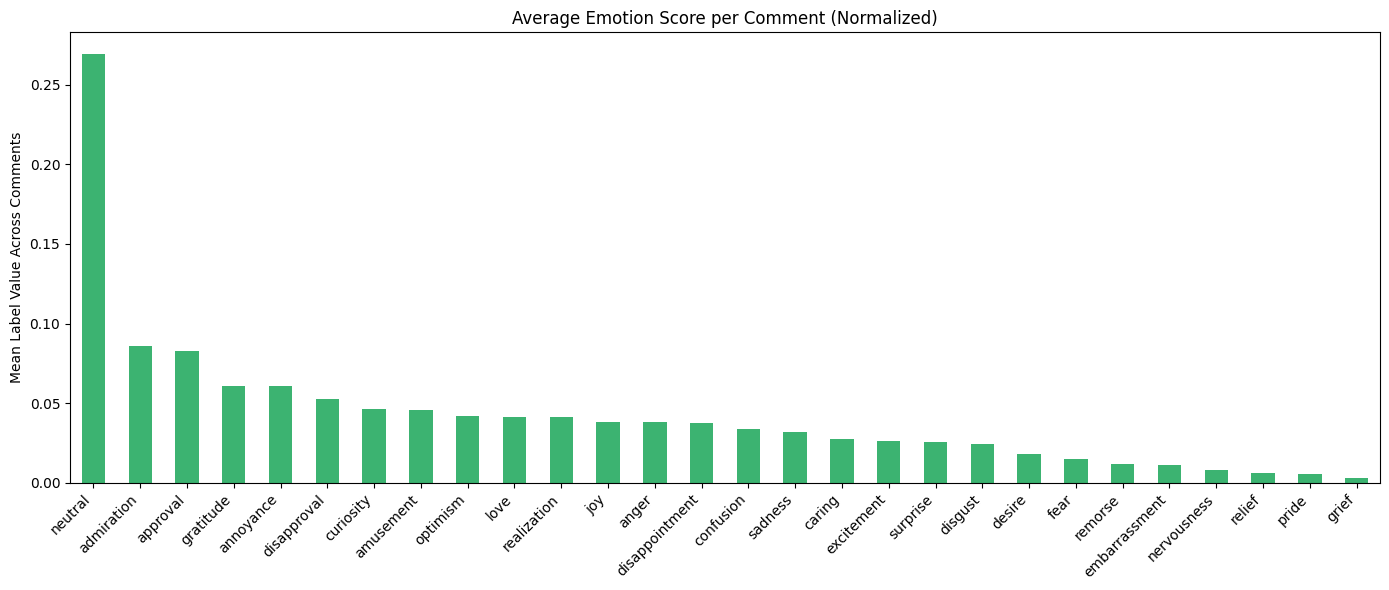

In [17]:
# !NB Now using df_clean
# Mean emotion score per comment (normalized, across all raters)
emotion_means = df_clean[emotion_cols].mean().sort_values(ascending=False)
emotion_means.plot(kind='bar', figsize=(14,6), color='mediumseagreen')
plt.title("Average Emotion Score per Comment (Normalized)")
plt.ylabel("Mean Label Value Across Comments")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show

## 🧇 ROUND 2: Relationships Between Emotions & Trustworthy Rebuild

We examine:
- Emotion co-occurrence
- Label correlation
- Rater-level noise (“neutral spam”)
- Comment-level contradictions

Then we rebuild the clean dataset excluding biased raters for deeper emotional mapping.

### Goals:
- Remove trust-breaking raters
- Map emotional overlap across Reddit
- Profile subreddit-specific emotion fingerprints

## Emotion Co-occurrence Matrix

FOR WHAT? → Dot product of binary/normalized labels → shows co-appearance.

SO WHAT? → Reveals if emotions like approval & admiration tend to appear together.

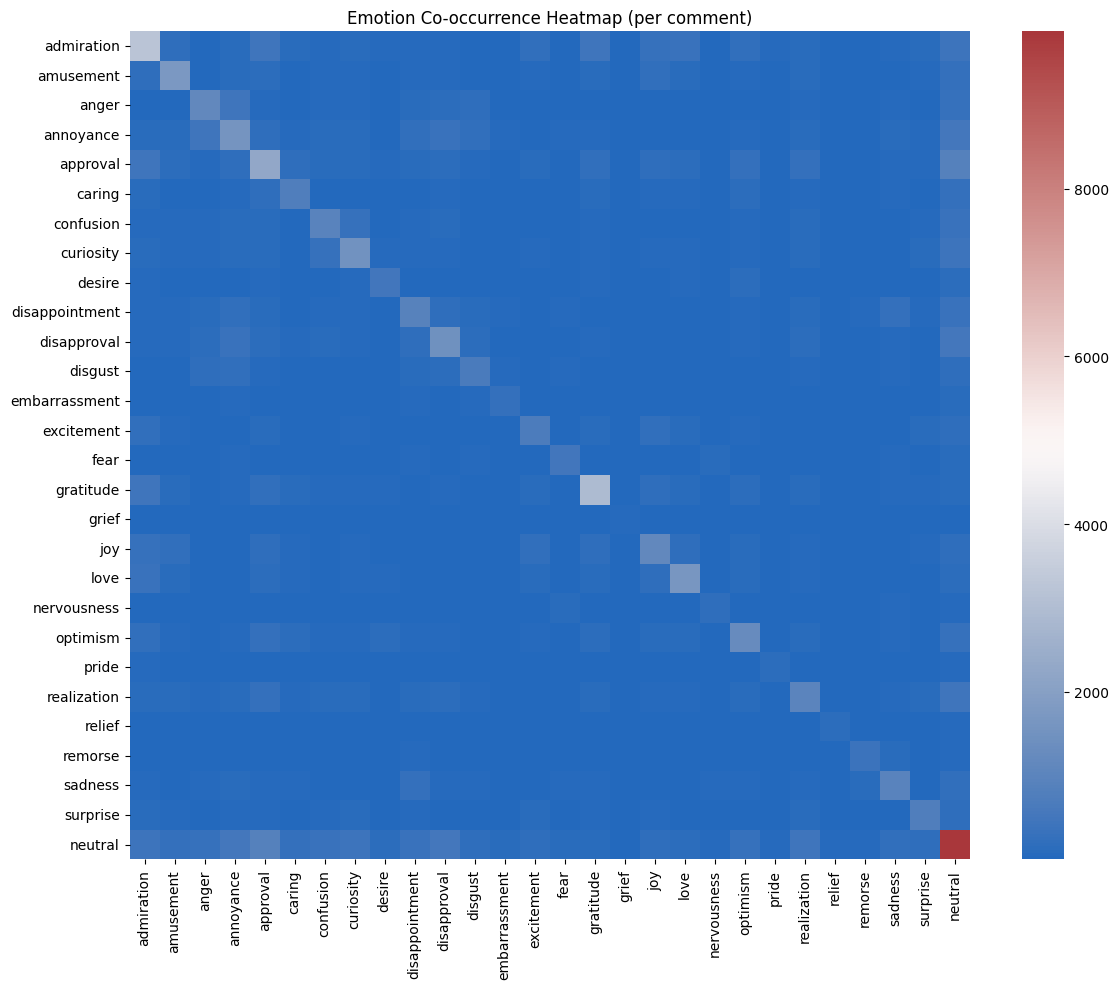

In [18]:
# Co-occurrence = how often emotions appear together across comments
co_occurrence = df_clean[emotion_cols].T.dot(df_clean[emotion_cols])

plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, cmap="vlag", annot=False)
plt.title("Emotion Co-occurrence Heatmap (per comment)")
plt.tight_layout()
plt.show()

## Without Neutral

FOR WHAT? → neutral dominates, so removing it reveals finer emotion links.

SO WHAT? → Shows actual emotion network, not noise from high-neutral skew.

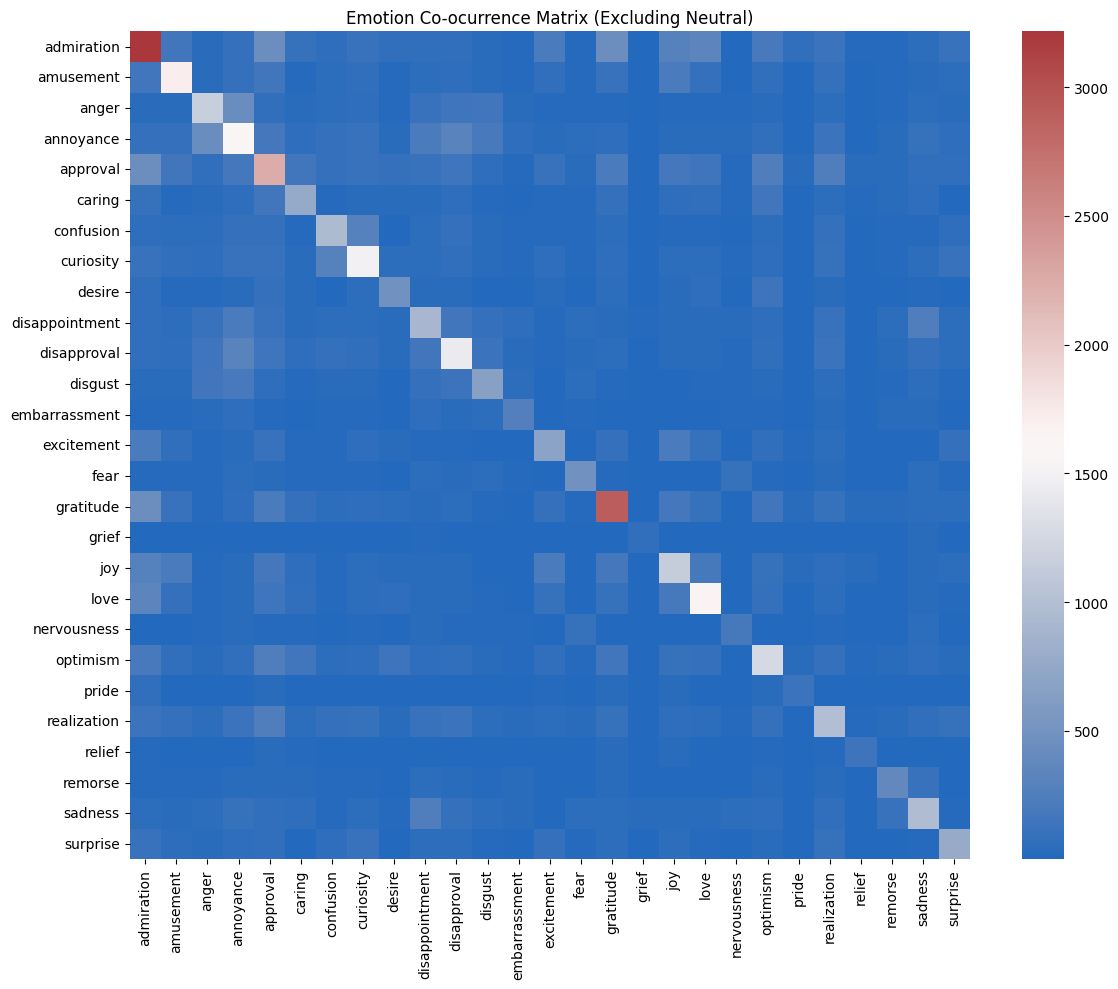

In [19]:
# Removing 'neutral' to better understand meaningful emotion co-occurrences
emotion_cols_no_neutral = [e for e in emotion_cols if e != "neutral"]

# Recompute correlation or co-occurrence without neutral
co_occurrence2 = df_clean[emotion_cols_no_neutral].T.dot(df_clean[emotion_cols_no_neutral])
# Plot again
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence2, cmap="vlag", annot=False)
plt.title("Emotion Co-ocurrence Matrix (Excluding Neutral)")
plt.tight_layout()
plt.show()

## Correlation Analysis

## Variance Check and NaN Check

FOR WHAT? → Avoid zero-variance columns in correlation cause these would distort the matrix.

SO WHAT? → Good data hygiene before correlation.

In [20]:
# Check for columns with zero variance
# Variance is a measure of how spread out the values are.
# If variance is 0, all values in the column are the same.
emotion_variances = df_clean[emotion_cols].var()
print("Variance of emotion columns:")
print(emotion_variances)

# Identify columns with zero variance
zero_variance_cols = emotion_variances[emotion_variances == 0].index.tolist()
print(f"\nColumns with zero variance: {zero_variance_cols}")

# Check for missing values (NaNs) in the emotion columns
print("\nMissing values per emotion column:")
print(df_clean[emotion_cols].isnull().sum())

# Check the total number of missing values in the emotion columns
total_missing_in_emotion_cols = df_clean[emotion_cols].isnull().sum().sum()
print(f"\nTotal missing values in emotion columns: {total_missing_in_emotion_cols}")

Variance of emotion columns:
admiration        0.048133
amusement         0.027535
anger             0.018328
annoyance         0.023301
approval          0.031754
caring            0.012336
confusion         0.015195
curiosity         0.023590
desire            0.008049
disappointment    0.014283
disapproval       0.021932
disgust           0.010637
embarrassment     0.004451
excitement        0.011232
fear              0.008214
gratitude         0.046509
grief             0.001106
joy               0.018171
love              0.026734
nervousness       0.003046
optimism          0.020104
pride             0.002124
realization       0.015329
relief            0.002232
remorse           0.006358
sadness           0.015551
surprise          0.012612
neutral           0.097616
dtype: float64

Columns with zero variance: []

Missing values per emotion column:
admiration        0
amusement         0
anger             0
annoyance         0
approval          0
caring            0
confusion   

## Correlation Matrix
Correlation shows linear dependence, not co-occurrence. Two emotions might appear together often (high co-occurrence) but still be uncorrelated in intensity.

FOR WHAT? → Statistical association (Pearson) between emotions

SO WHAT? → Helps in feature engineering, emotion grouping, or modeling.

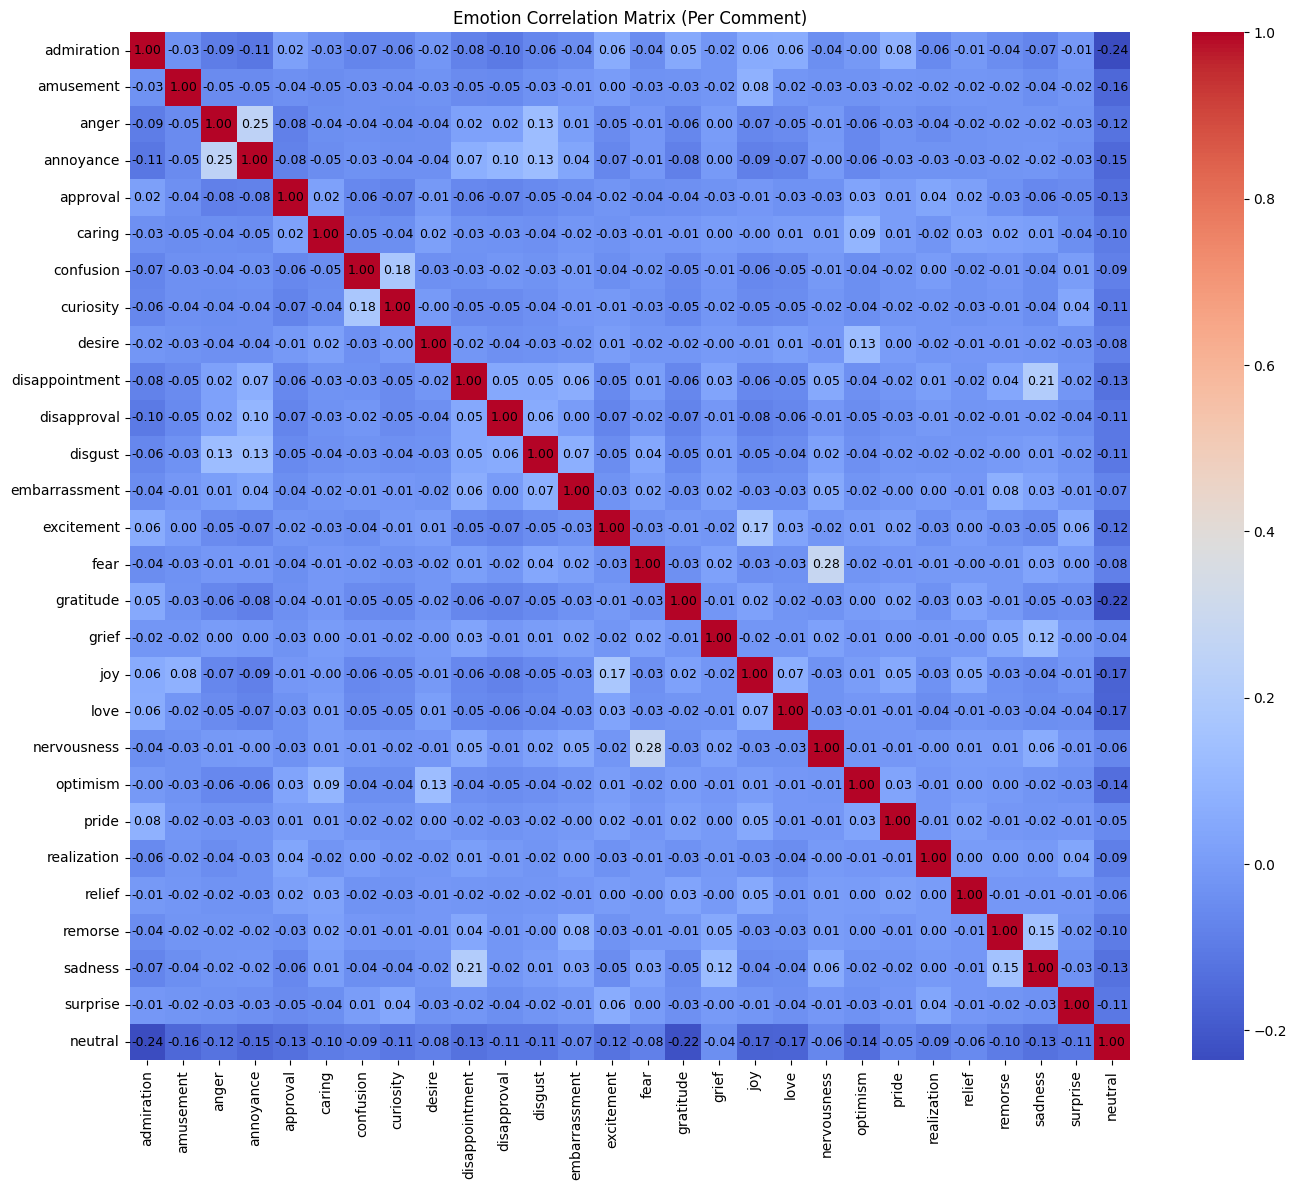

In [21]:
plt.figure(figsize=(14, 12))
sns.heatmap(df_clean[emotion_cols].corr(), cmap="coolwarm", annot=True, fmt=".2f",
            annot_kws={'fontsize': 9, 'color': 'black'})
plt.title("Emotion Correlation Matrix (Per Comment)")
plt.tight_layout()
plt.show()




## Histogram of Emotion Count per Comment

FOR WHAT? → Counts how many emotions each comment expresses.

SO WHAT? → Gives insight into multi-label nature, i.e., how “emotionally rich” Reddit comments are.

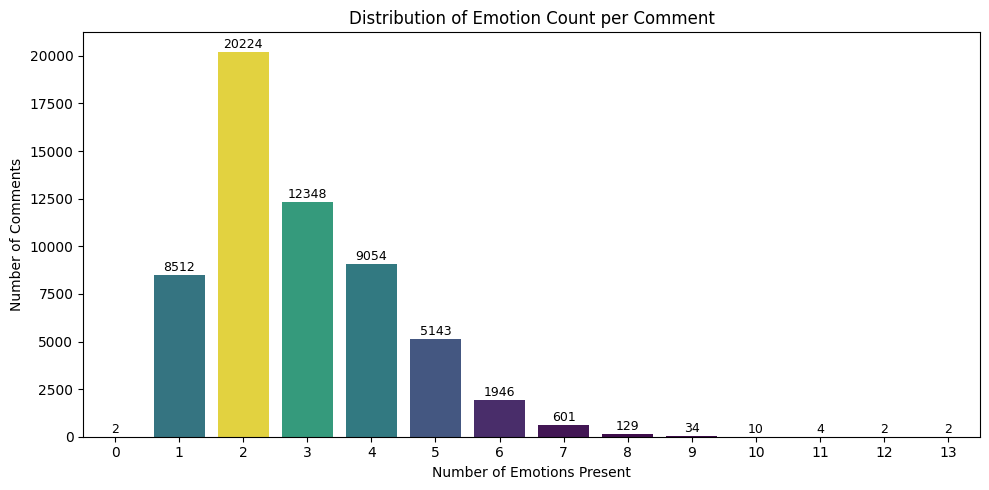

In [22]:
# Histogram: How many emotions are expressed per comment
df_clean['emotion_count'] = df_clean[emotion_cols].gt(0).sum(axis=1)

# Calculate the frequency of each emotion count
emotion_count_distribution = df_clean['emotion_count'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
# Create a colormap
cmap = cm.viridis

# Normalize the values to the range of the colormap
norm = colors.Normalize(vmin=emotion_count_distribution.values.min(), vmax=emotion_count_distribution.values.max())

# Get colors for each bar based on its value
bar_colors = [cmap(norm(value)) for value in emotion_count_distribution.values]

# Create the bar plot with the specified colors
ax = sns.barplot(x=emotion_count_distribution.index, y=emotion_count_distribution.values, palette=bar_colors)

# Add numbers on top of the bars
for i, v in enumerate(emotion_count_distribution.values):
    ax.text(i, v + 50, str(v), ha='center', va='bottom', fontsize=9)

plt.title("Distribution of Emotion Count per Comment")
plt.xlabel("Number of Emotions Present")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0) # Keep x-axis labels horizontal for readability
plt.tight_layout()
plt.show()

In [23]:
df_clean[df_clean['emotion_count'] == 13]

id                                               text  \
10096  edelx9y  Two or three anti depressants before I told th...   
11414  edgmob1  Welcome to racial integration, where your civi...   

             subreddit         created_utc  admiration  amusement  anger  \
10096  benzodiazepines 2019-01-06 19:07:42    0.333333        0.0    0.0   
11414   TrueOffMyChest 2019-01-07 10:19:45    0.200000        0.0    0.2   

       annoyance  approval  caring  ...  optimism     pride  realization  \
10096        0.0  0.333333     0.0  ...  0.333333  0.333333     0.333333   
11414        0.4  0.200000     0.2  ...  0.000000  0.000000     0.000000   

       relief   remorse  sadness  surprise   neutral  rater_count  \
10096     0.0  0.333333      0.0       0.0  0.333333            3   
11414     0.0  0.000000      0.2       0.0  0.000000            5   

       emotion_count  
10096             13  
11414             13  

[2 rows x 34 columns]

## Compare 1-Rater vs Multi-Rater Comments

FOR WHAT? → Find if multi-rater consensus changes emotional profile

SO WHAT? → Insight into label trustworthiness and noise, useful in modeling and weighting.

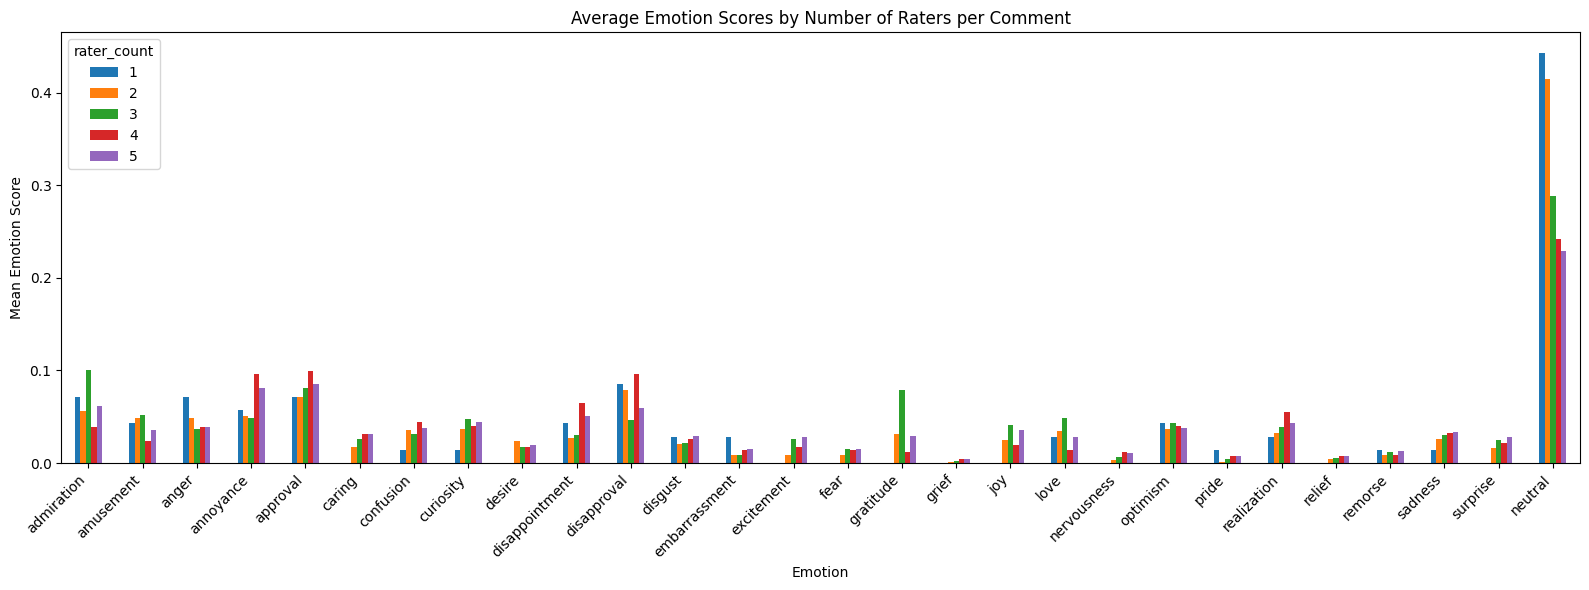

In [24]:
# Does more rater agreement lead to different emotional profiles?

# Create grouped means by rater count
emotion_by_ratergroup = df_clean.groupby('rater_count')[emotion_cols].mean()

# Plot
emotion_by_ratergroup.T.plot(kind='bar', figsize=(16, 6))
plt.title("Average Emotion Scores by Number of Raters per Comment")
plt.ylabel("Mean Emotion Score")
plt.xlabel("Emotion")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## ! Rater Bias Heatmap

FOR WHAT? → Heatmap of each rater’s style/preferences

SO WHAT? → Shows labeling subjectivity, potential for rater-specific filtering.

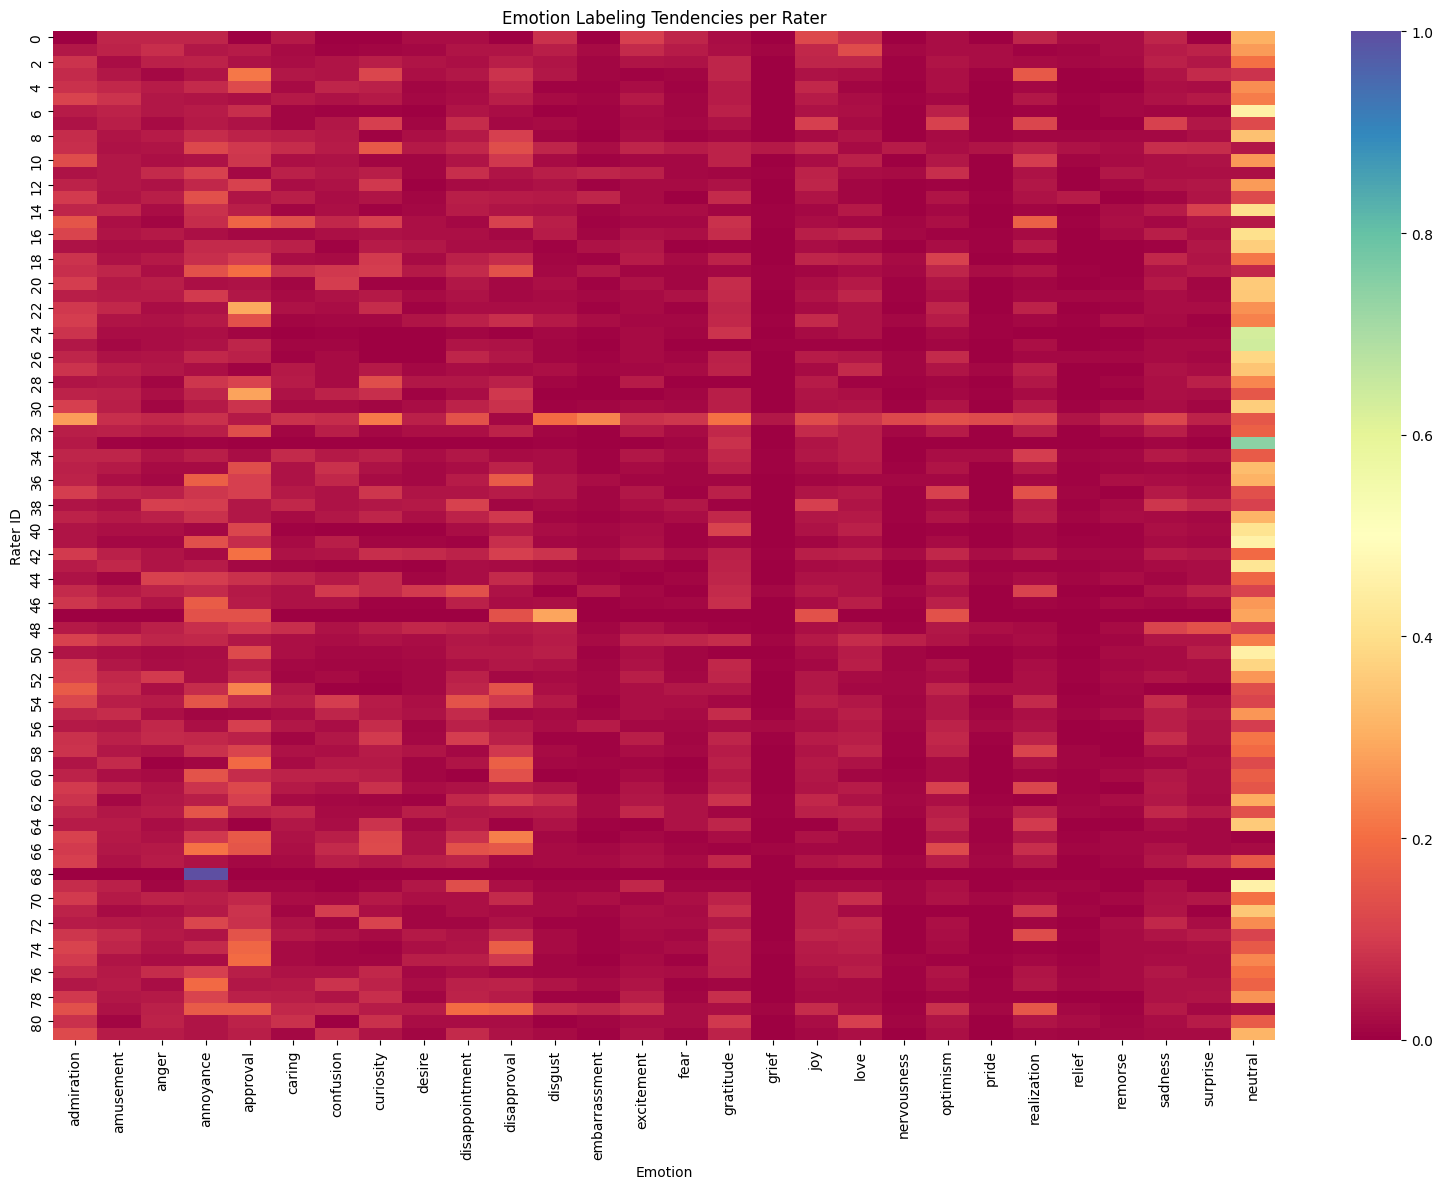

In [25]:
# Heatmap: How different raters tend to use each emotion label

rater_emotion_means = df.groupby('rater_id')[emotion_cols].mean()

plt.figure(figsize=(16, 12))
sns.heatmap(rater_emotion_means, cmap="Spectral", annot=False)
plt.title("Emotion Labeling Tendencies per Rater")
plt.xlabel("Emotion")
plt.ylabel("Rater ID")
plt.tight_layout()
plt.show()

## Identifying “Neutral Spammers” & Their Labeling Patterns

## Robust Rater Filtering

FOR WHAT? → Ensures that we only judge raters with enough data.

SO WHAT? → Prevents statistical noise from small sample bias.

In [26]:
# Only include raters with ≥30 annotations to avoid skew

# Step 1: Create robust rater set (≥ 30 comments)
robust_threshold = 30

rater_stats = df.groupby('rater_id')['neutral'].agg(['mean', 'count']).reset_index()
rater_stats.columns = ['rater_id', 'neutral_mean', 'num_comments']

# Use .copy() to ensure robust_rater_stats is an independent DataFrame
robust_rater_stats = rater_stats[rater_stats['num_comments'] >= robust_threshold].copy()


## Visual Outliers in Neutral Use


FOR WHAT? → Show rater-wise neutral usage distribution

SO WHAT? → Exposes extreme values (potential biasers)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


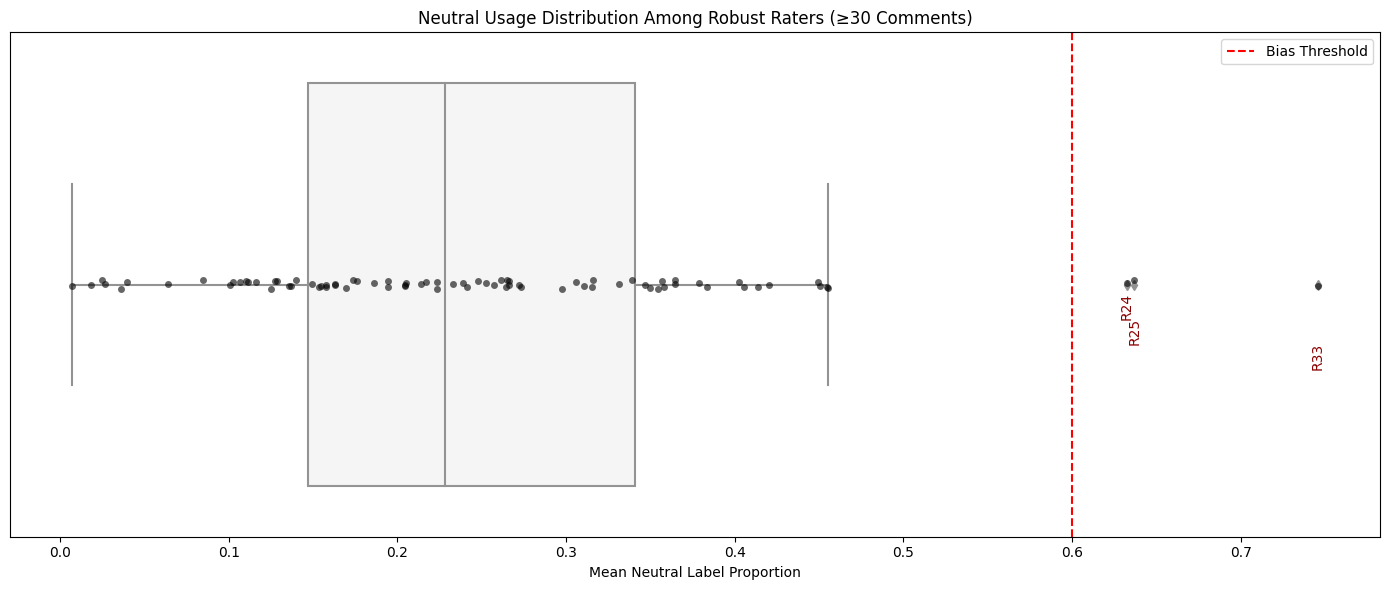

In [27]:
robust_rater_stats['neutral_mean'] = robust_rater_stats['neutral_mean'].replace([np.inf, -np.inf], np.nan)

# Create the figure for the plots
plt.figure(figsize=(14, 6))

# Box plot to show the spread
sns.boxplot(x=robust_rater_stats['neutral_mean'], color='whitesmoke')

# Stripplot to show individual rater points
sns.stripplot(x=robust_rater_stats['neutral_mean'], color='black', alpha=0.6, jitter=0.01)

# Flag raters who used 'neutral' in >60% of their labels
bias_threshold = 0.6
biased = robust_rater_stats[robust_rater_stats['neutral_mean'] >= bias_threshold]

for i, (index, row) in enumerate(biased.iterrows()):
    y_offset = 0.07 + (i * 0.05)  # increasing separation
    plt.text(row['neutral_mean'], y_offset, f"R{int(row['rater_id'])}",
             rotation=90, fontsize=10, color='darkred', ha='center', va='bottom')

plt.title("Neutral Usage Distribution Among Robust Raters (≥30 Comments)")
plt.xlabel("Mean Neutral Label Proportion")
plt.yticks([]) # Hide y-axis ticks as they are not meaningful here
plt.axvline(x=bias_threshold, color='red', linestyle='--', label='Bias Threshold')
plt.legend()
plt.tight_layout()
plt.show()

## Mean/Median Neutral Stats

FOR WHAT? → Gives central tendency baseline

SO WHAT? → Contextualizes whether “neutral spam” is truly abnormal or within spread

In [28]:
# Calculate mean and median neutral frequency per rater
rater_neutral_freq = df.groupby('rater_id')['neutral'].mean()

neutral_mean = rater_neutral_freq.mean()
neutral_median = rater_neutral_freq.median()

print(f"Mean neutral frequency across raters: {neutral_mean:.4f}")
print(f"Median neutral frequency across raters: {neutral_median:.4f}")

Mean neutral frequency across raters: 0.2438
Median neutral frequency across raters: 0.2281


## Zoom on Biased Raters

FOR WHAT? → Slice rows from the 3 biased raters

SO WHAT? → Check labeling patterns, volume, comment coverage

In [29]:
# Explore how many comments and total rows were touched by known overneutral raters

biased_raters_neutral = df[df['rater_id'].isin([24, 25, 33])]
biased_raters_neutral.shape  # Total rows they labeled

biased_raters_neutral['id'].nunique()  # Unique comments they rated

9477

In [30]:
biased_raters_neutral.groupby('rater_id')['neutral'].mean()

rater_id
24    0.632361
25    0.636856
33    0.745723
Name: neutral, dtype: float64

## Tag & Analyze Over-Neutral Raters

FOR WHAT? → Flag rows labeled by suspicious raters

SO WHAT? → Can later be filtered, weighted, or excluded

In [31]:
# Add binary flag: was the labeler an over-neutral rater?
over_neutral_raters = [24, 25, 33]
df['overneutral_rater'] = df['rater_id'].isin(over_neutral_raters).astype(int)
df

text       id  \
0                                         That game hurt.  eew5j0j   
1        >sexuality shouldn’t be a grouping category I...  eemcysk   
2          You do right, if you don't care then fuck 'em!  ed2mah1   
3                                      Man I love reddit.  eeibobj   
4       [NAME] was nowhere near them, he was by the Fa...  eda6yn6   
...                                                   ...      ...   
211220                             Everyone likes [NAME].  ee6pagw   
211221  Well when you’ve imported about a gazillion of...  ef28nod   
211222                                 That looks amazing  ee8hse1   
211223  The FDA has plenty to criticize. But like here...  edrhoxh   
211224  Desktop link: ^^/r/HelperBot_ ^^Downvote ^^to ...  edze9g4   

                     author            subreddit    link_id   parent_id  \
0                     Brdd9                  nrl  t3_ajis4z  t1_eew18eq   
1               TheGreen888     unpopularopinion  t3_ai4q37   t3_ai4q37   
2                  Labalool          confessions  t3_abru74  t1_ed2m7g7   
3             MrsRobertshaw             facepalm  t3_ahulml   t3_ahulml   
4       American_Fascist713  starwarsspeculation  t3_ackt2f  t1_eda65q2   
...                     ...                  ...        ...         ...   
211220             Senshado     heroesofthestorm  t3_agjf24   t3_agjf24   
211221           5inchloser          nottheonion  t3_ak26t3   t3_ak26t3   
211222           springt1me       shittyfoodporn  t3_agrnqb   t3_agrnqb   
211223            enamedata             medicine  t3_aejqzd  t1_edrgdtx   
211224           HelperBot_        MorbidReality  t3_afhw30  t1_edze91s   

               created_utc  rater_id  example_very_unclear  admiration  ...  \
0      2019-01-25 01:50:39         1                 False           0  ...   
1      2019-01-21 15:22:49        37                  True           0  ...   
2      2019-01-02 11:15:44        37                 False           0  ...   
3      2019-01-20 06:17:34        18                 False           0  ...   
4      2019-01-05 06:10:01         2                 False           0  ...   
...                    ...       ...                   ...         ...  ...   
211220 2019-01-16 10:25:22        16                 False           0  ...   
211221 2019-01-27 01:39:42        15                 False           0  ...   
211222 2019-01-17 00:08:54        70                 False           1  ...   
211223 2019-01-11 01:07:12         4                 False           0  ...   
211224 2019-01-13 16:34:22        61                  True           0  ...   

        realization  relief  remorse  sadness  surprise  neutral  year  month  \
0                 0       0        0        1         0        0  2019      1   
1                 0       0        0        0         0        0  2019      1   
2                 0       0        0        0         0        1  2019      1   
3                 0       0        0        0         0        0  2019      1   
4                 0       0        0        0         0        1  2019      1   
...             ...     ...      ...      ...       ...      ...   ...    ...   
211220            0       0        0        0         0        0  2019      1   
211221            0       0        0        0         0        0  2019      1   
211222            0       0        0        0         0        0  2019      1   
211223            0       0        0        0         0        0  2019      1   
211224            0       0        0        0         0        0  2019      1   

        day  overneutral_rater  
0        25                  0  
1        21                  0  
2         2                  0  
3        20                  0  
4         5                  0  
...     ...                ...  
211220   16                  0  
211221   27                  0  
211222   17                  0  
211223   11                  0  
211224   13               

In [32]:
# Do overneutral raters disproportionately label 'very unclear' comments?
df.groupby('overneutral_rater')['example_very_unclear'].mean()


overneutral_rater
0    0.016858
1    0.001896
Name: example_very_unclear, dtype: float64

## Joint Breakdown

FOR WHAT? → Interaction between bad raters × bad inputs

SO WHAT? → Pinpoints if these raters collapse under ambiguity

In [33]:
# How over-neutral raters behave on unclear comments

df.groupby(['overneutral_rater', 'example_very_unclear'])['neutral'].mean()

overneutral_rater  example_very_unclear
0                  False                   0.245064
                   True                    0.000000
1                  False                   0.682100
                   True                    0.000000
Name: neutral, dtype: float64

## ! df_nobias_raw
## ! df_nobias_clean
## Clean Dataset Rebuild (Excluding Neutral-Spam Raters)

rebuilding df_clean using only trusted raters, removing IDs 24, 25, and 33. This improves signal quality for subreddit-level emotional profiling.

## Remove Biased Raters

FOR WHAT? → Remove known noisy labelers.

SO WHAT? → Improves clarity in downstream stats & visualizations.

In [34]:
# Step 1: Remove known biased raters (IDs 24, 25, 33)
biased_raters = [24, 25, 33]
df_nobias_raw = df[~df['rater_id'].isin(biased_raters)]
df_nobias_raw

text       id  \
0                                         That game hurt.  eew5j0j   
1        >sexuality shouldn’t be a grouping category I...  eemcysk   
2          You do right, if you don't care then fuck 'em!  ed2mah1   
3                                      Man I love reddit.  eeibobj   
4       [NAME] was nowhere near them, he was by the Fa...  eda6yn6   
...                                                   ...      ...   
211220                             Everyone likes [NAME].  ee6pagw   
211221  Well when you’ve imported about a gazillion of...  ef28nod   
211222                                 That looks amazing  ee8hse1   
211223  The FDA has plenty to criticize. But like here...  edrhoxh   
211224  Desktop link: ^^/r/HelperBot_ ^^Downvote ^^to ...  edze9g4   

                     author            subreddit    link_id   parent_id  \
0                     Brdd9                  nrl  t3_ajis4z  t1_eew18eq   
1               TheGreen888     unpopularopinion  t3_ai4q37   t3_ai4q37   
2                  Labalool          confessions  t3_abru74  t1_ed2m7g7   
3             MrsRobertshaw             facepalm  t3_ahulml   t3_ahulml   
4       American_Fascist713  starwarsspeculation  t3_ackt2f  t1_eda65q2   
...                     ...                  ...        ...         ...   
211220             Senshado     heroesofthestorm  t3_agjf24   t3_agjf24   
211221           5inchloser          nottheonion  t3_ak26t3   t3_ak26t3   
211222           springt1me       shittyfoodporn  t3_agrnqb   t3_agrnqb   
211223            enamedata             medicine  t3_aejqzd  t1_edrgdtx   
211224           HelperBot_        MorbidReality  t3_afhw30  t1_edze91s   

               created_utc  rater_id  example_very_unclear  admiration  ...  \
0      2019-01-25 01:50:39         1                 False           0  ...   
1      2019-01-21 15:22:49        37                  True           0  ...   
2      2019-01-02 11:15:44        37                 False           0  ...   
3      2019-01-20 06:17:34        18                 False           0  ...   
4      2019-01-05 06:10:01         2                 False           0  ...   
...                    ...       ...                   ...         ...  ...   
211220 2019-01-16 10:25:22        16                 False           0  ...   
211221 2019-01-27 01:39:42        15                 False           0  ...   
211222 2019-01-17 00:08:54        70                 False           1  ...   
211223 2019-01-11 01:07:12         4                 False           0  ...   
211224 2019-01-13 16:34:22        61                  True           0  ...   

        realization  relief  remorse  sadness  surprise  neutral  year  month  \
0                 0       0        0        1         0        0  2019      1   
1                 0       0        0        0         0        0  2019      1   
2                 0       0        0        0         0        1  2019      1   
3                 0       0        0        0         0        0  2019      1   
4                 0       0        0        0         0        1  2019      1   
...             ...     ...      ...      ...       ...      ...   ...    ...   
211220            0       0        0        0         0        0  2019      1   
211221            0       0        0        0         0        0  2019      1   
211222            0       0        0        0         0        0  2019      1   
211223            0       0        0        0         0        0  2019      1   
211224            0       0        0        0         0        0  2019      1   

        day  overneutral_rater  
0        25                  0  
1        21                  0  
2         2                  0  
3        20                  0  
4         5                  0  
...     ...                ...  
211220   16                  0  
211221   27                  0  
211222   17                  0  
211223   11                  0  
211224   13               

## Rebuild Grouped Dataset

Same structure as original df_clean, now based on df_nobias_raw

This is "shadow-clean" dataset, critical for interpretability - rebuild per-comment emotion scores using debiased data


In [35]:
# Step 2: Group by comment ID to get average emotion scores
df_nobias_grouped = df_nobias_raw.groupby('id')[emotion_cols].mean()

# Step 3: Grab meta fields (text, subreddit, etc.)
df_nobias_meta = df_nobias_raw.groupby('id')[['text', 'subreddit', 'created_utc']].first()

# Step 4: Merge into clean comment-level dataset
df_nobias_clean = pd.concat([df_nobias_meta, df_nobias_grouped], axis=1).reset_index()
df_nobias_clean

id                                               text  \
0      eczazk6  Fast as [NAME] will carry me. Seriously uptown...   
1      eczb07q        You blew it. They played you like a fiddle.   
2      eczb4bm  TL;DR No more Superbowls for [NAME]. Get ready...   
3      eczb527                           So much time saved. Not.   
4      eczb6r7  Emotes have a ridiculous amount of effort put ...   
...        ...                                                ...   
57999  efhclgb  [NAME]. I’m not sure you’ll feel the same way ...   
58000  efhcm78    I can see why! I would totally be offended too!   
58001  efhcnhz  Approaching doesn't work unless you are [NAME]...   
58002  efhcreo                                    Hahaha perfect.   
58003  efhcuxi                              Ok now that was epic!   

               subreddit         created_utc  admiration  amusement  anger  \
0             NewOrleans 2019-01-01 00:00:19    0.000000   0.000000    0.0   
1                   self 2019-01-01 00:00:34    0.000000   0.000000    0.0   
2               steelers 2019-01-01 00:02:14    0.000000   0.000000    0.0   
3                Roadcam 2019-01-01 00:02:32    0.000000   0.000000    0.0   
4              Blackops4 2019-01-01 00:03:14    0.000000   0.000000    0.0   
...                  ...                 ...         ...        ...    ...   
57999       bodybuilding 2019-01-31 23:53:59    0.000000   0.000000    0.0   
58000       greysanatomy 2019-01-31 23:54:24    0.000000   0.000000    0.0   
58001       ForeverAlone 2019-01-31 23:55:22    0.000000   0.000000    0.0   
58002  CollegeBasketball 2019-01-31 23:57:48    0.666667   0.333333    0.0   
58003        PUBGXboxOne 2019-01-31 23:59:36    0.333333   0.000000    0.0   

       annoyance  approval  caring  ...  love  nervousness  optimism  pride  \
0            0.0      1.00     0.0  ...   0.0          0.0       0.0    0.0   
1            0.0      0.00     0.0  ...   0.0          0.0       0.0    0.0   
2            0.0      0.00     0.0  ...   0.0          0.0       0.0    0.0   
3            0.0      0.00     0.0  ...   0.0          0.0       0.0    0.0   
4            0.0      0.25     0.0  ...   0.0          0.0       0.0    0.0   
...          ...       ...     ...  ...   ...          ...       ...    ...   
57999        0.0      0.00     0.0  ...   0.0          0.0       0.0    0.0   
58000        0.4      0.20     0.0  ...   0.0          0.0       0.0    0.0   
58001        0.0      0.00     0.0  ...   0.0          0.0       0.0    0.0   
58002        0.0      0.00     0.0  ...   0.0          0.0       0.0    0.0   
58003        0.0      0.00     0.0  ...   0.0          0.0       0.0    0.0   

       realization  relief  remorse  sadness  surprise   neutral  
0             0.00     0.0      0.0     0.00       0.0  0.000000  
1             0.00     0.0      0.0     0.00       0.0  1.000000  
2             0.00     0.0      0.0     0.00       0.0  0.000000  
3             0.00     0.0      0.0     0.00       0.0  0.000000  
4             0.25     0.0      0.0     0.25       0.0  0.250000  
...            ...     ...      ...      ...       ...       ...  
57999         0.00     0.0      0.0     0.00       0.0  0.000000  
58000         0.20     0.0      0.0     0.20       0.0  0.000000  
58001         0.00     0.0      0.0     0.00       0.0  1.000000  
58002         0.00     0.0      0.0     0.00       0.0  0.000000  
58003         0.00     0.0      0.0     0.00       0.0  0.666667  

[58004 rows x 32 columns]

## Subreddit Emotion Profiling

## Basic Grouping

FOR WHAT? → Calculate subreddit-level emotional signatures.

SO WHAT? → Lets us profile communities by affective tone.

In [36]:
# Average emotion score per subreddit (based on debiased dataset)

subreddit_emotions = df_nobias_clean.groupby('subreddit')[emotion_cols].mean()
subreddit_emotions

admiration  amusement     anger  annoyance  approval  \
subreddit                                                                     
2meirl4meirl             0.066839   0.039637  0.027807   0.045769  0.056131   
49ers                    0.080747   0.059291  0.046360   0.072126  0.059770   
4PanelCringe             0.074306   0.119965  0.050868   0.040017  0.088715   
90DayFiance              0.096836   0.069753  0.028318   0.067284  0.077392   
90dayfianceuncensored    0.058974   0.071418  0.039970   0.050452  0.085596   
...                           ...        ...       ...        ...       ...   
worldpolitics            0.047980   0.050758  0.053535   0.111490  0.073990   
yesyesyesyesno           0.080867   0.056633  0.073810   0.082823  0.060714   
youseeingthisshit        0.122401   0.048566  0.050000   0.053853  0.066308   
youtube                  0.033176   0.044025  0.045912   0.088679  0.088050   
youtubehaiku             0.059072   0.069198  0.029325   0.045781  0.080591   

                         caring  confusion  curiosity    desire  \
subreddit                                                         
2meirl4meirl           0.035233   0.035320   0.041796  0.020207   
49ers                  0.015134   0.028736   0.033716  0.027586   
4PanelCringe           0.010243   0.026562   0.042622  0.008941   
90DayFiance            0.011420   0.039738   0.063194  0.027392   
90dayfianceuncensored  0.022926   0.051735   0.063725  0.011161   
...                         ...        ...        ...       ...   
worldpolitics          0.016667   0.035732   0.033460  0.010606   
yesyesyesyesno         0.014116   0.032993   0.036310  0.014966   
youseeingthisshit      0.025806   0.030376   0.050627  0.019982   
youtube                0.014465   0.053302   0.077201  0.007547   
youtubehaiku           0.040928   0.021097   0.050211  0.013502   

                       disappointment  ...      love  nervousness  optimism  \
subreddit                              ...                                    
2meirl4meirl                 0.076339  ...  0.045682     0.017185  0.033679   
49ers                        0.057759  ...  0.041379     0.007567  0.052107   
4PanelCringe                 0.039757  ...  0.044965     0.006858  0.021788   
90DayFiance                  0.043981  ...  0.050309     0.008333  0.024923   
90dayfianceuncensored        0.027753  ...  0.038537     0.000905  0.029110   
...                               ...  ...       ...          ...       ...   
worldpolitics                0.043687  ...  0.019571     0.005556  0.032197   
yesyesyesyesno               0.042432  ...  0.042177     0.012160  0.021684   
youseeingthisshit            0.023297  ...  0.029839     0.005735  0.040143   
youtube                      0.025472  ...  0.030660     0.015566  0.029874   
youtubehaiku                 0.036287  ...  0.064979     0.002532  0.028692   

                          pride  realization    relief   remorse   sadness  \
subreddit                                                                    
2meirl4meirl           0.006131     0.039724  0.003109  0.024180  0.096632   
49ers                  0.003736     0.040230  0.005651  0.006130  0.032375   
4PanelCringe           0.006250     0.030208  0.002604  0.011632  0.042274   
90DayFiance            0.001157     0.048688  0.005556  0.005170  0.016204   
90dayfianceuncensored  0.005354     0.038989  0.002413  0.004299  0.021719   
...                         ...          ...       ...       ...       ...   
worldpolitics          0.001515     0.041919  0.000000  0.023106  0.029545   
yesyesyesyesno         0.008418     0.034694  0.004422  0.005017  0.037075   
youseeingthisshit      0.003943     0.030914  0.006093  0.002151  0.034946   
youtube                0.000000     0.042767  0.025943  0.032075  0.023742   
youtubehaiku           0.002532     0.044726  0.004219  0.011603  0.016878   

                       surprise   neutral  
subreddit                           

## Emotion Fingerprint of Top 20 Subreddits

FOR WHAT? → Visualize which subreddits express which emotions

SO WHAT? → Surface-level but impactful - viewers instantly spot patterns (e.g., anger in r/politics, curiosity in r/askscience)

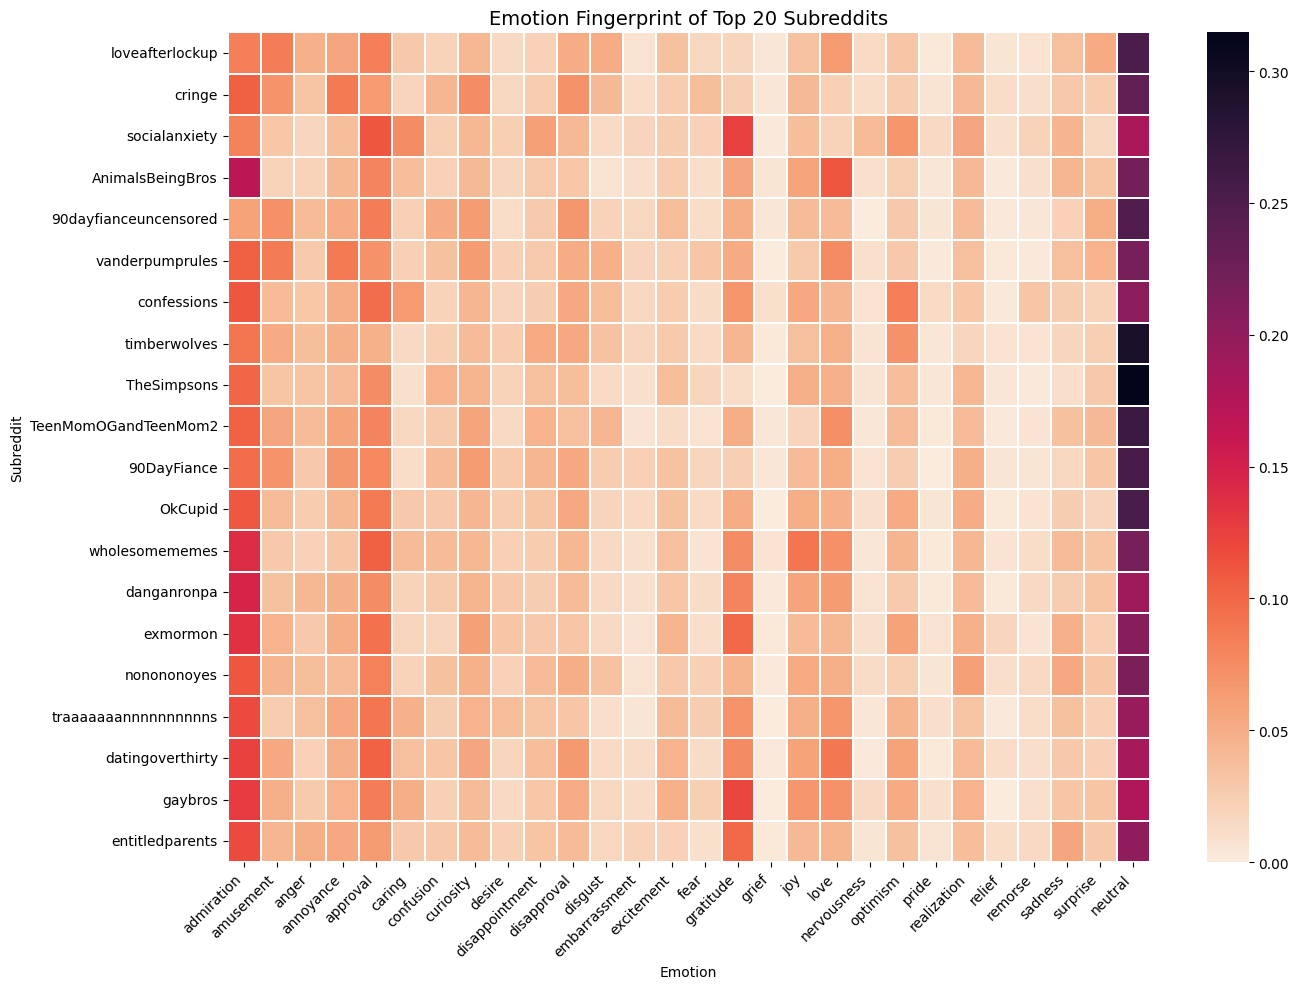

In [37]:
# Subreddit emotion fingerprint
subreddit_emotions = df_nobias_clean.groupby('subreddit')[emotion_cols].mean()

# Limit to top 20 most active subreddits (by comment count)
top_subs = df_nobias_clean['subreddit'].value_counts().head(20).index
subreddit_emotions_top = subreddit_emotions.loc[top_subs]

# Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(subreddit_emotions_top, cmap='rocket_r', annot=False, linewidths=0.3)
plt.title("Emotion Fingerprint of Top 20 Subreddits", fontsize=14)
plt.ylabel("Subreddit")
plt.xlabel("Emotion")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## ! Focused Emotion Barplot (e.g. Top 10)

In [38]:
subreddit_emotions_top['neutral'].sort_values(ascending=False)

subreddit
TheSimpsons              0.314688
timberwolves             0.292652
TeenMomOGandTeenMom2     0.266206
90DayFiance              0.254552
OkCupid                  0.254206
loveafterlockup          0.252697
90dayfianceuncensored    0.248793
cringe                   0.235565
AnimalsBeingBros         0.221789
wholesomememes           0.219860
vanderpumprules          0.219759
nonononoyes              0.215476
exmormon                 0.207233
confessions              0.203864
entitledparents          0.200976
traaaaaaannnnnnnnnns     0.195317
danganronpa              0.189875
datingoverthirty         0.184696
socialanxiety            0.182974
gaybros                  0.177564
Name: neutral, dtype: float64

FOR WHAT? → Focused deep dive on one emotion.

SO WHAT? → Allows qualitative interpretation: “Where is this emotion dominant?”

In [39]:
import plotly.express as px

emotion_to_plot = 'anger'  # or 'joy', etc.
top_em_subs = subreddit_emotions[emotion_to_plot].sort_values(ascending=False).head(10).reset_index()

fig = px.bar(top_em_subs, x=emotion_to_plot, y='subreddit', orientation='h',
             color=emotion_to_plot, color_continuous_scale='Reds',
             title=f"Top 10 Subreddits by '{emotion_to_plot.title()}' Score")
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

## Loop: Top 3 Subreddits per Emotion

FOR WHAT? → Create a fast reference map from emotion x subreddit

SO WHAT? → Useful in summary, dashboards, or stakeholder comms

In [40]:
# Build dictionary of top 3 subreddits per emotion (summary-style output)

# Store results
top_emotions_by_subreddit = {}

# Loop: for each emotion, get top 3 subreddits
for emotion in emotion_cols:
    top_subs = subreddit_emotions[emotion].sort_values(ascending=False).head(3)
    top_emotions_by_subreddit[emotion] = list(top_subs.index)

# Print results in text format
for emotion, top_subs in top_emotions_by_subreddit.items():
    print(f"{emotion.title()}:")
    for i, sub in enumerate(top_subs, start=1):
        print(f"   {i}. {sub}")
    print()

Admiration:
   1. lgbt
   2. dogswithjobs
   3. Music

Amusement:
   1. ComedyCemetery
   2. dadjokes
   3. 4PanelCringe

Anger:
   1. CryptoCurrency
   2. nottheonion
   3. Unexpected

Annoyance:
   1. LateStageCapitalism
   2. AskThe_Donald
   3. mildlyinfuriating

Approval:
   1. InstacartShoppers
   2. NarcissisticAbuse
   3. dating_advice

Caring:
   1. SuicideWatch
   2. survivinginfidelity
   3. NarcissisticAbuse

Confusion:
   1. Flipping
   2. philosophy
   3. disneyvacation

Curiosity:
   1. changemyview
   2. JordanPeterson
   3. socialism

Desire:
   1. jobs
   2. SoulCalibur
   3. askcarsales

Disappointment:
   1. FortniteCompetitive
   2. TeamSolomid
   3. TwoBestFriendsPlay

Disapproval:
   1. AskALiberal
   2. DebateAnAtheist
   3. PoliticalDiscussion

Disgust:
   1. GifRecipes
   2. ATBGE
   3. ExpectationVsReality

Embarrassment:
   1. muacirclejerk
   2. WhyWereTheyFilming
   3. blogsnark

Excitement:
   1. drunk
   2. Futurology
   3. SpoiledDragRace

Fear:
   1. t

## 🥞 ROUND 3: Language Structure, Signal Conflicts & Predictive Emotion Mapping

Now we dive into the text itself:
- How do emotion labels relate to actual language?
- Can “neutral” labels be trusted?
- Which comments trigger disagreement?
- Can we predict emotion labels with text?

### Tools:
- Linguistic features
- Co-occurrence patterns
- Word2Vec + t-SNE
- TF-IDF
- Logistic Regression

## Text Length, Word Count, Exclamation Count, Emotion Count, is_neutral_only

FOR WHAT? → Build linguistic feature set to detect mislabeled or low-informational “neutral” cases.

SO WHAT? → Supports both qualitative audit and predictive modeling. Useful for downstream LLM or ML diagnostics

In [41]:
# Linguistic features that may correlate with emotional labeling bias

# Add comment length in characters
df_nobias_clean['text_length'] = df_nobias_clean['text'].str.len()

# Add word count (simple whitespace split)
df_nobias_clean['word_count'] = df_nobias_clean['text'].str.split().apply(len)

# Optional: punctuation count (emotional intensity cue)
df_nobias_clean['exclaim_count'] = df_nobias_clean['text'].str.count('!')

# Add "emotion richness" — number of emotions above 0
df_nobias_clean['emotion_count'] = df_nobias_clean[emotion_cols].gt(0).sum(axis=1)

# Binary label: is the comment neutral-only?
df_nobias_clean['is_neutral_only'] = (df_nobias_clean['neutral'] > 0) & (df_nobias_clean['emotion_count'] == 1)

# View preview
df_nobias_clean[['text', 'text_length', 'word_count', 'exclaim_count', 'emotion_count', 'is_neutral_only']].head()

# for future analysis: capslock_ratio: percent of ALLCAPS words (might correlate with anger, excitement), question_mark_count: curiosity/confusion proxy, emoji_presence: if applicable (GoEmotions originally included emoji analysis).

text  text_length  word_count  \
0  Fast as [NAME] will carry me. Seriously uptown...           96          17   
1        You blew it. They played you like a fiddle.           43           9   
2  TL;DR No more Superbowls for [NAME]. Get ready...          102          16   
3                           So much time saved. Not.           24           5   
4  Emotes have a ridiculous amount of effort put ...          111          20   

   exclaim_count  emotion_count  is_neutral_only  
0              0              1            False  
1              0              1             True  
2              0              1            False  
3              0              2            False  
4              0              5            False

## Melt + Boxplots by is_neutral_only

FOR WHAT? → Visualize how “neutral-only” differs from emotionally tagged comments

SO WHAT? → If exclamations or long comments get neutral-only tags → labeling flaw detected.

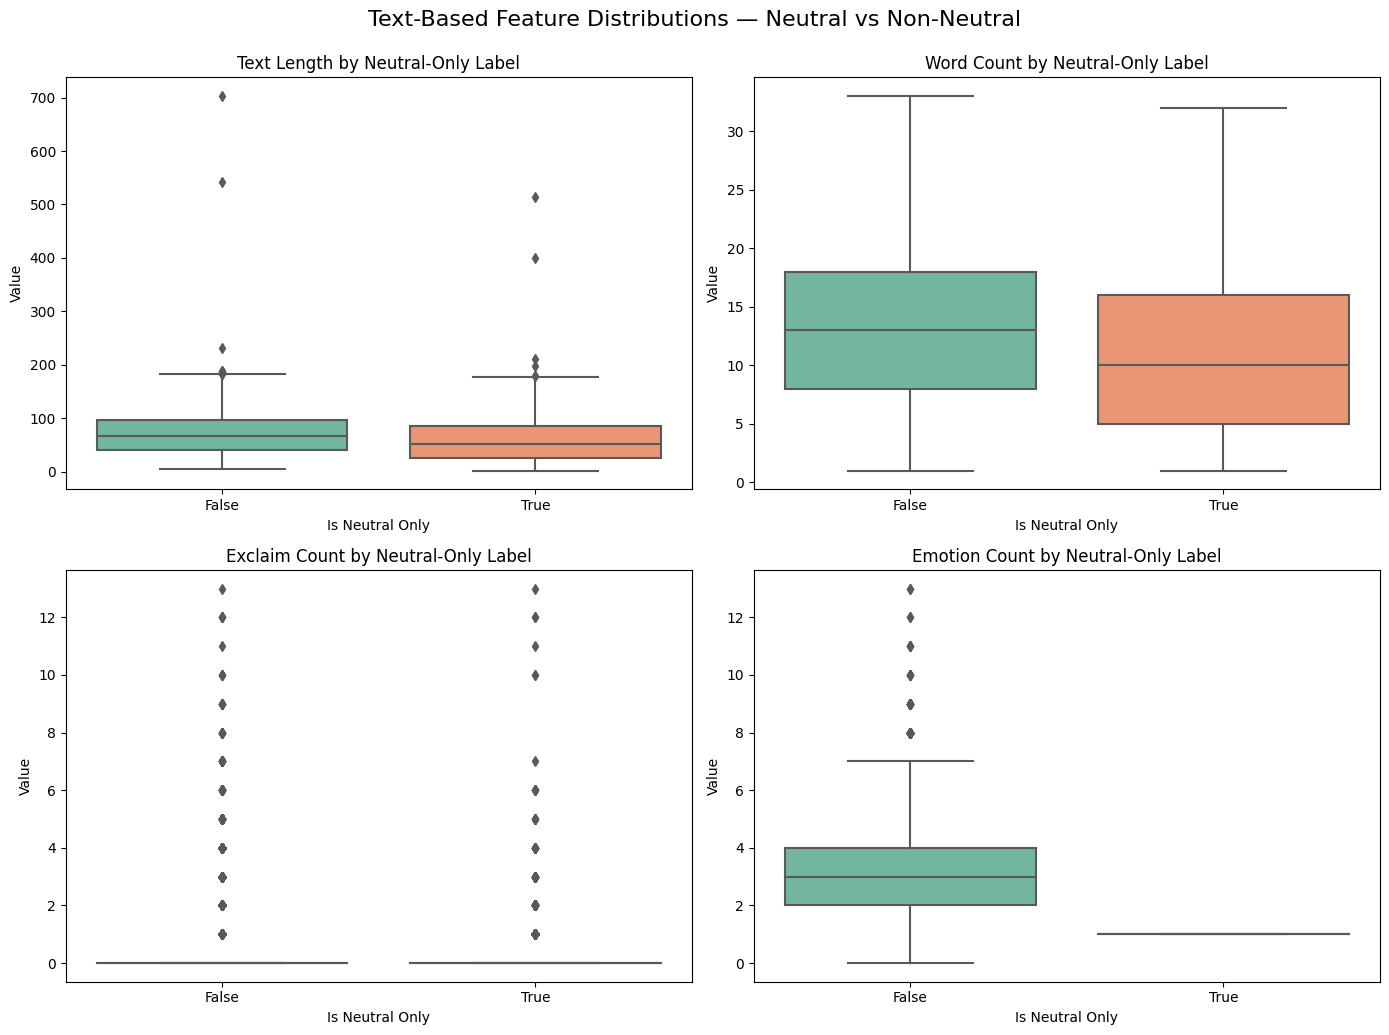

In [42]:
# Melt for easy plotting
melted = df_nobias_clean.melt(
    id_vars='is_neutral_only',
    value_vars=['text_length', 'word_count', 'exclaim_count', 'emotion_count'],
    var_name='feature',
    value_name='value'
)
melted


features = ['text_length', 'word_count', 'exclaim_count', 'emotion_count']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(
        data=df_nobias_clean,
        x='is_neutral_only',
        y=feature,
        palette='Set2',
        ax=axes[i]
    )
    axes[i].set_title(f"{feature.replace('_', ' ').title()} by Neutral-Only Label")
    axes[i].set_xlabel("Is Neutral Only")
    axes[i].set_ylabel("Value")

plt.tight_layout()
plt.suptitle("Text-Based Feature Distributions — Neutral vs Non-Neutral", fontsize=16, y=1.03)
plt.show()

In [43]:
df_nobias_clean.groupby('is_neutral_only')['exclaim_count'].mean()

is_neutral_only
False    0.205173
True     0.175265
Name: exclaim_count, dtype: float64

In [44]:
# Show neutral-only comments with at least 1 exclamation mark
df_nobias_clean[
    (df_nobias_clean['is_neutral_only']) &
    (df_nobias_clean['exclaim_count'] > 0)
][['text', 'exclaim_count']].sort_values(by='exclaim_count', ascending=False).head(20)

text  exclaim_count
3475                                 DUTCHY!!!!!!!!!!!!!             13
31600                                    MDC!!!!!!!!!!!!             12
35546             # SOMEONE GIVE THIS GOLD!!!!!!!!!!!! #             12
44192                                  #SILKY!!!!!!!!!!!             11
12953                                      Yes!!!!!!!!!!             10
14611                           im pickle rick!!!!!!!!!!             10
31831  "RUDY! RUDY! RUDY! RUDY! RUDY! RUDY! RUDY!" Co...              7
48785                     TWO YEARS!!! WE TOLD YOU SO!!!              6
40169                                  KAMALA 2020!!!!!!              6
36049                 tHiS iS wHY TruMP wiLL wiN!!!!!1!1              6
27820  This!!! This!!! Is the definition of a choosy ...              6
8828   [NAME]. The third generation [RELIGION] stripp...              6
48119  They’ve made it far more serious than necessar...              6
42825  Har--HARRY POTTER! **HARRY POTTER!!!** I KNOW ...              5
31890                                   FBI!! OPEN UP!!!              5
17517                                    Hallelujah!!!!!              5
52297                          [NAME] WHO IS [NAME]!!!!!              5
22916  Drinking and cussing = toxic masculinity Every...              5
20739                         CAPTAIN!! ye-yeah? LOOK!!!              5
36574             BUT YOUNG MASTER, MY ***JUSTICE***!!!!              4

## Flag Possible Misratings (Neutral + Exclamations)

FOR WHAT → Flags semantic-linguistic contradictions
SO WHAT? → Strengthens case for label trust analysis

In [45]:
df_nobias_clean['possible_misrating'] = (
    df_nobias_clean['is_neutral_only'] &
    (df_nobias_clean['exclaim_count'] > 0)
)
df_nobias_clean['possible_misrating'].mean()

0.007947727742914282

In [46]:
# Consider for future modelling
df_nobias_clean_exclm = df_nobias_clean[~df_nobias_clean['possible_misrating']]

## Contradiction: Neutral + Other Emotions

FOR WHAT? → Detects cases where neutral is used together with strong emotions

SO WHAT? → Should never happen — either the comment has emotion or it’s neutral.

In [47]:
emotion_cols_no_neutral = [col for col in emotion_cols if col != 'neutral']
df['emotion_count_ex_neutral'] = df[emotion_cols_no_neutral].gt(0).sum(axis=1)
emotion_cols_no_neutral

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise']

In [48]:
df_contradictions = df[
    (df['neutral'] > 0) &
    (df['emotion_count_ex_neutral'] > 0)
][['id', 'rater_id', 'text', 'neutral'] + emotion_cols_no_neutral]
df_contradictions

Empty DataFrame
Columns: [id, rater_id, text, neutral, admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief, remorse, sadness, surprise]
Index: []

[0 rows x 31 columns]

In [49]:
print(f"Total contradiction cases: {len(df_contradictions)}")
print(f"Unique raters involved: {df_contradictions['rater_id'].nunique()}")

Total contradiction cases: 0
Unique raters involved: 0


## Contradiction: Multi-Emotion from Single Rater

FOR WHAT? → Detects raters assigning 3+ emotions in one go

SO WHAT? → May reflect rich emotion or lazy over-tagging

In [50]:
# Step 1: Define emotion columns (without neutral if needed)
emotion_cols_no_neutral = [col for col in emotion_cols if col != 'neutral']

# Step 2: Count how many emotions each rater assigned for each comment
df['emotion_count_per_rater'] = df[emotion_cols_no_neutral].gt(0).sum(axis=1)

# Step 3: Filter for comments with more than one emotion from a single rater
df_multi_emotions_by_rater = df[df['emotion_count_per_rater'] > 1]

# Step 4: Preview
print(f"Total multi-emotion ratings by individual raters: {len(df_multi_emotions_by_rater)}")
df_multi_emotions_by_rater[['id', 'rater_id', 'text'] + emotion_cols_no_neutral].sample(10)


Total multi-emotion ratings by individual raters: 35994


id  rater_id                                               text  \
9616    ee64xkc        21  I was wondering if that would happen. The stor...   
176171  ee5zsz6        37  Also put icecream under the taco for a nice su...   
139247  eesng7r        23  Thank you! I am surprised with the amount of f...   
44850   edok6gs        52  They’re usually not great actually. I’m shocke...   
48181   edrrx9c         3  Love both flags man! I was on my college campu...   
42236   ef6n1tb        37  Point is to hold you to some standard of evide...   
33884   ef03i9l        61  That chick at the end. She just gets sucked on...   
1451    efd6je1         3  Intresting. Well I sure did learn something to...   
73653   ef4u1z2        15  You just defended him with a bunch of doublesp...   
37074   edz1xpn        15  Yes. He was. Fuck off with your bullshit doubl...   

        admiration  amusement  anger  annoyance  approval  caring  confusion  \
9616             0          0      0          0         0       0          0   
176171           1          0      0          0         0       0          0   
139247           0          0      0          0         0       0          0   
44850            1          0      0          0         0       0          0   
48181            0          0      0          0         0       0          0   
42236            0          0      1          1         0       0          0   
33884            0          0      0          0         1       0          0   
1451             0          0      0          0         0       0          0   
73653            0          0      0          1         0       1          0   
37074            0          0      1          0         1       0          0   

        ...  joy  love  nervousness  optimism  pride  realization  relief  \
9616    ...    0     0            0         0      0            0       0   
176171  ...    0     0            0         0      0            0       0   
139247  ...    0     0            0         0      0            0       0   
44850   ...    0     0            0         0      0            0       0   
48181   ...    0     0            0         1      0            0       0   
42236   ...    0     0            0         0      0            0       0   
33884   ...    0     0            0         0      0            1       0   
1451    ...    0     0            0         1      0            1       0   
73653   ...    0     0            0         0      0            0       0   
37074   ...    0     0            0         0      0            0       0   

        remorse  sadness  surprise  
9616          0        0         1  
176171        0        0         1  
139247        0        0         1  
44850         0        0         1  
48181         0        0         1  
42236         0        0         0  
33884         0        0         0  
1451          0        0         0  
73653         0        0         0  
37074         0        0         0  

[10 rows x 30 columns]

## ! Co-occurrence from Individual Raters

FOR WHAT? → Empirically measure emotion blends across all raters

SO WHAT? → Reveals high-signal pairings (e.g. anger + disgust, love + joy)

In [51]:
# Step 1: Define emotion columns (without neutral if needed)
emotion_cols_no_neutral = [col for col in emotion_cols if col != 'neutral']

# Function to count emotion pairs
def get_top_emotion_pairs(df_multi, emotion_cols):
    pair_counter = Counter()
    for _, row in df_multi.iterrows():
        active = [e for e in emotion_cols if row[e] > 0]
        for pair in combinations(active, 2):
            pair_counter[tuple(sorted(pair))] += 1
    return pair_counter

pair_counter = get_top_emotion_pairs(df_multi_emotions_by_rater, emotion_cols_no_neutral)

# Convert to DataFrame
top_pairs = pair_counter.most_common(20)
df_top_pairs = pd.DataFrame(top_pairs, columns=['Emotion Pair', 'Count'])
df_top_pairs


Emotion Pair  Count
0              (anger, annoyance)   1391
1          (admiration, approval)   1366
2         (admiration, gratitude)   1165
3        (annoyance, disapproval)   1039
4       (disappointment, sadness)    907
5               (excitement, joy)    869
6         (approval, realization)    829
7          (confusion, curiosity)    754
8     (annoyance, disappointment)    754
9            (approval, optimism)    748
10             (admiration, love)    721
11              (admiration, joy)    652
12          (approval, gratitude)    620
13         (admiration, optimism)    603
14           (annoyance, disgust)    599
15            (fear, nervousness)    492
16         (disapproval, disgust)    482
17       (admiration, excitement)    475
18  (disappointment, disapproval)    471
19             (approval, caring)    442

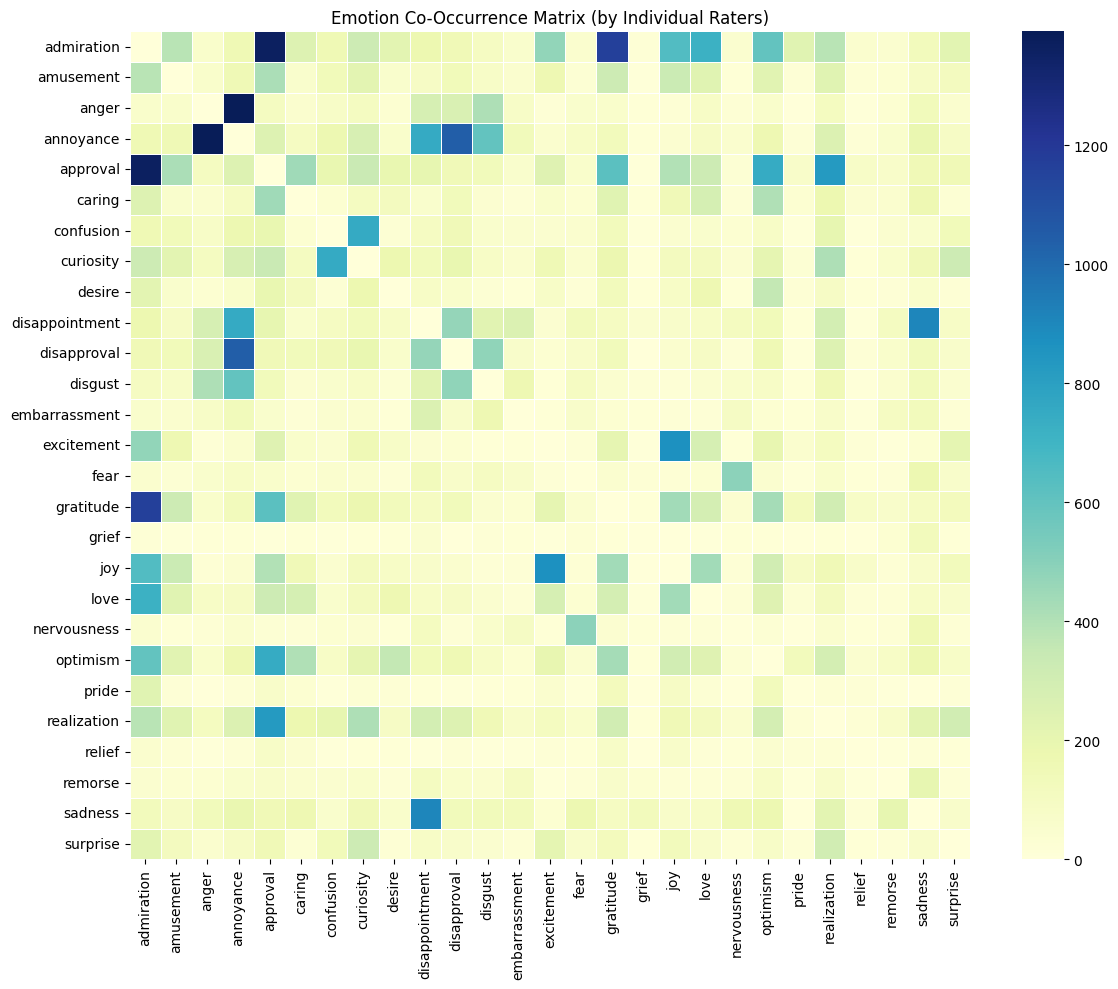

In [52]:
# Create empty matrix
matrix = pd.DataFrame(0, index=emotion_cols_no_neutral, columns=emotion_cols_no_neutral)

# Fill matrix with counts
for (e1, e2), count in pair_counter.items():
    matrix.loc[e1, e2] += count
    matrix.loc[e2, e1] += count  # make it symmetric

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matrix, cmap='YlGnBu', linewidths=0.5)
plt.title('Emotion Co-Occurrence Matrix (by Individual Raters)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Samples: Emotionally Extreme or Complex Comments

FOR WHAT? → Highlight meaningful real-world cases

SO WHAT? → Anchors abstract numbers in real text — good for storytelling or model prompt crafting.

In [53]:
# Top 5 comments with highest joy
top_joy = df_nobias_clean.sort_values('joy', ascending=False)[['text', 'joy']].head(5)

# Top 5 comments with highest anger
top_anger = df_nobias_clean.sort_values('anger', ascending=False)[['text', 'anger']].head(5)

# Top 5 comments with highest fear
top_fear = df_nobias_clean.sort_values('fear', ascending=False)[['text', 'fear']].head(5)

# Top 5 comments with highest emotional complexity (emotion_count >= 4)
high_complexity = df_nobias_clean[df_nobias_clean['emotion_count'] >= 4][['text', 'emotion_count']].head(5)

# Show all together
pd.concat([
    top_joy.assign(type='joy'),
    top_anger.assign(type='anger'),
    top_fear.assign(type='fear'),
    high_complexity.assign(type='complex')
])

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



text  joy     type  anger  \
28836  This is a really lovely ends to a crappy means...  1.0      joy    NaN   
48256                                    mystery solved.  1.0      joy    NaN   
23133  I played for a decade+ on release, I'd be happ...  1.0      joy    NaN   
37127        i actually laughed at that lol good one man  1.0      joy    NaN   
2011          Try it sometime man. You may just enjoy it  1.0      joy    NaN   
19414  Yeah I know what you meant. Fuck the police, m...  NaN    anger    1.0   
54896  I spent the entire time trying not to yell at ...  NaN    anger    1.0   
21574                                     Shut up [NAME]  NaN    anger    1.0   
6238                  He must really hate changing dies.  NaN    anger    1.0   
1087   was i replying to you, you fucking degenerate?...  NaN    anger    1.0   
4665   I took a picture of a farmer treating his crop...  NaN     fear    NaN   
34429  Confirmation sounds really scary and sketchy. ...  NaN     fear    NaN   
40526         I’m afraid it will eventually go that way.  NaN     fear    NaN   
54575  Aaaand I'm still here. I don't have a alt acco...  NaN     fear    NaN   
55725                             Please don’t murder me  NaN     fear    NaN   
4      Emotes have a ridiculous amount of effort put ...  NaN  complex    NaN   
7      *they were not* 😂 perfect. I’m sure they were ...  NaN  complex    NaN   
9      To be fair you haev to have a very high iq to ...  NaN  complex    NaN   
13     If things were not as they are, they would be ...  NaN  complex    NaN   
15     I would cheer hard for a Cyborg win in that to...  NaN  complex    NaN   

       fear  emotion_count  
28836   NaN            NaN  
48256   NaN            NaN  
23133   NaN            NaN  
37127   NaN            NaN  
2011    NaN            NaN  
19414   NaN            NaN  
54896   NaN            NaN  
21574   NaN            NaN  
6238    NaN            NaN  
1087    NaN            NaN  
4665    1.0            NaN  
34429   1.0            NaN  
40526   1.0            NaN  
54575   1.0            NaN  
55725   1.0            NaN  
4       NaN            5.0  
7       NaN            4.0  
9       NaN            5.0  
13      NaN            4.0  
15      NaN            4.0

## Pull Comments with Most Rater Overlap

FOR WHAT? → Find out which comments attracted multiple interpretations

SO WHAT → Useful for consensus analysis or gold-standard test sets

In [54]:
emotion_cols = df.columns[df.columns.get_loc('admiration'):df.columns.get_loc('neutral') + 1]

# Count how many times each comment ID appears (each appearance = a rater)
top_shared_ids = df['id'].value_counts().head(10)

# Pull all rows (rater-level) for those top 10 comments
# Ensure all original columns are kept
df_top_shared = df[df['id'].isin(top_shared_ids.index)].copy()

# Preview the full emotional spread for each of the top 10 shared comments

cols_to_display = ['id', 'rater_id', 'text'] + emotion_cols.tolist()
display(df_top_shared[cols_to_display].sort_values(by='id').head(30))

id  rater_id                                               text  \
200811  ed1djsl        61  I mean, if I make it look like an accident, ju...   
149224  ed1djsl        56  I mean, if I make it look like an accident, ju...   
187939  ed1djsl        72  I mean, if I make it look like an accident, ju...   
23814   ed1djsl        28  I mean, if I make it look like an accident, ju...   
57347   ed1djsl        37  I mean, if I make it look like an accident, ju...   
86355   ed9km8y        78  Fascinating, can you please provide some more ...   
23815   ed9km8y        66  Fascinating, can you please provide some more ...   
75490   ed9km8y        37  Fascinating, can you please provide some more ...   
34337   ed9km8y        19  Fascinating, can you please provide some more ...   
161133  ed9km8y        16  Fascinating, can you please provide some more ...   
209601  edebf9q        60  Love the way his body just folds after the fin...   
81066   edebf9q        35  Love the way his body just folds after the fin...   
153268  edebf9q        30  Love the way his body just folds after the fin...   
126990  edebf9q         7  Love the way his body just folds after the fin...   
196490  edebf9q         4  Love the way his body just folds after the fin...   
187388  eduz4po        60  I feel horrible for the government workers cau...   
81079   eduz4po         1  I feel horrible for the government workers cau...   
152903  eduz4po        24  I feel horrible for the government workers cau...   
109937  eduz4po        57  I feel horrible for the government workers cau...   
124470  eduz4po        46  I feel horrible for the government workers cau...   
43287   edxckdl        20  The cost of centralized mandatory services is ...   
23796   edxckdl        81  The cost of centralized mandatory services is ...   
136311  edxckdl        62  The cost of centralized mandatory services is ...   
209599  edxckdl        61  The cost of centralized mandatory services is ...   
164037  edxckdl        39  The cost of centralized mandatory services is ...   
176407  ee8wvo4        30                                   Let’s gooooo WHI   
190817  ee8wvo4        48                                   Let’s gooooo WHI   
141360  ee8wvo4        61                                   Let’s gooooo WHI   
101131  ee8wvo4        27                                   Let’s gooooo WHI   
23807   ee8wvo4         4                                   Let’s gooooo WHI   

        admiration  amusement  anger  annoyance  approval  caring  confusion  \
200811           0          0      0          0         1       0          0   
149224           0          0      0          0         0       0          1   
187939           0          0      0          0         0       0          0   
23814            0          0      0          0         0       0          0   
57347            0          0      0          0         1       0          0   
86355            0          0      0          0         0       0          0   
23815            1          0      0          0         1       0          0   
75490            0          0      0          0         0       0          0   
34337            1          0      0          0         0       0          0   
161133           0          0      0          0         0       0          0   
209601           0          1      0          0         0       0          0   
81066            0          0      0          0         0       0          0   
153268           0          0      0          0         0       0          0   
126990           0          0      0          0         0       0          0   
196490           0          0      0          0         0       0          0   
187388           0          0      0          0         0       0          0   
81079            0          0      0          0         0       0          0   
152903           0          0      0          0         0       0          0   
109937      

In [55]:
# Aggregate to show number of unique emotions each comment got
df_top_shared.groupby('id')[emotion_cols].sum().gt(0).sum(axis=1).sort_values(ascending=False)

id
ed9km8y    7
ed1djsl    6
eev5l0o    6
eduz4po    5
eeem310    4
eew5j0j    4
edebf9q    3
efeuvbz    3
ee8wvo4    2
edxckdl    1
dtype: int64

## Calculate variance per emotion for each top shared comment

FOR WHAT? → For each of the top 10 most-rated comments, calculate the variance of each emotion label across raters.

SO WHAT? → Tells us:

Where raters agreed (low variance)

Where they conflicted (high variance)

Which emotions cause the most confusion

In [56]:
# Group by comment ID → calculate variance of each emotion
df_variance_per_emotion = (
    df_top_shared
    .groupby('id')[emotion_cols]
    .var()
)

In [57]:
# Show top 10 shared comments with emotion label variances
df_variance_per_emotion.round(3)

admiration  amusement  anger  annoyance  approval  caring  confusion  \
id                                                                              
ed1djsl         0.0        0.0    0.0        0.0       0.3     0.0        0.2   
ed9km8y         0.3        0.0    0.0        0.0       0.2     0.0        0.0   
edebf9q         0.0        0.2    0.0        0.0       0.0     0.0        0.0   
eduz4po         0.0        0.0    0.0        0.0       0.0     0.0        0.0   
edxckdl         0.0        0.0    0.0        0.0       0.0     0.0        0.0   
ee8wvo4         0.0        0.0    0.0        0.0       0.0     0.0        0.0   
eeem310         0.0        0.0    0.0        0.0       0.0     0.0        0.3   
eev5l0o         0.0        0.3    0.0        0.2       0.0     0.0        0.0   
eew5j0j         0.0        0.0    0.0        0.0       0.0     0.0        0.0   
efeuvbz         0.0        0.0    0.0        0.0       0.3     0.0        0.0   

         curiosity  desire  disappointment  ...  love  nervousness  optimism  \
id                                          ...                                
ed1djsl        0.0     0.0             0.2  ...   0.0          0.0       0.3   
ed9km8y        0.2     0.2             0.0  ...   0.0          0.0       0.0   
edebf9q        0.0     0.0             0.0  ...   0.3          0.0       0.0   
eduz4po        0.0     0.0             0.2  ...   0.0          0.0       0.3   
edxckdl        0.0     0.0             0.0  ...   0.0          0.0       0.0   
ee8wvo4        0.0     0.0             0.0  ...   0.0          0.0       0.0   
eeem310        0.2     0.0             0.0  ...   0.0          0.0       0.0   
eev5l0o        0.0     0.0             0.0  ...   0.0          0.0       0.0   
eew5j0j        0.0     0.0             0.2  ...   0.0          0.0       0.0   
efeuvbz        0.0     0.0             0.0  ...   0.0          0.0       0.0   

         pride  realization  relief  remorse  sadness  surprise  neutral  
id                                                                        
ed1djsl    0.0          0.0     0.0      0.0      0.0       0.0      0.0  
ed9km8y    0.0          0.0     0.0      0.0      0.0       0.0      0.2  
edebf9q    0.0          0.0     0.0      0.0      0.0       0.0      0.0  
eduz4po    0.0          0.0     0.0      0.0      0.3       0.0      0.2  
edxckdl    0.0          0.0     0.0      0.0      0.0       0.0      0.0  
ee8wvo4    0.0          0.0     0.0      0.0      0.0       0.0      0.3  
eeem310    0.0          0.0     0.0      0.0      0.0       0.2      0.2  
eev5l0o    0.0          0.0     0.0      0.0      0.0       0.0      0.2  
eew5j0j    0.0          0.0     0.0      0.2      0.3       0.0      0.2  
efeuvbz    0.0          0.0     0.0      0.0      0.0       0.0      0.3  

[10 rows x 28 columns]

## Highlight Most Controversial Emotions Per Comment

In [58]:
# Find top variance emotion per comment
top_var_emotion = df_variance_per_emotion.idxmax(axis=1)
top_var_score = df_variance_per_emotion.max(axis=1)

# Combine into a summary
comment_disagreement_summary = pd.DataFrame({
    'Top_Var_Emotion': top_var_emotion,
    'Variance_Score': top_var_score
})

In [59]:
display(comment_disagreement_summary.sort_values(by='Variance_Score', ascending=False))

Top_Var_Emotion  Variance_Score
id                                     
ed1djsl        approval             0.3
eduz4po         sadness             0.3
eeem310       confusion             0.3
ed9km8y      admiration             0.3
edebf9q            love             0.3
ee8wvo4         neutral             0.3
eev5l0o       amusement             0.3
eew5j0j         sadness             0.3
efeuvbz        approval             0.3
edxckdl      admiration             0.0

## Emotion Disagreement Histogram for all dataset

FOR WHAT? → Measure how much raters disagree per comment.

SO WHAT? → Surfaces labeling noise, complex emotion, or ambiguous text. Good to define thresholds (e.g. high disagreement > 0.4) and label outliers in plot.

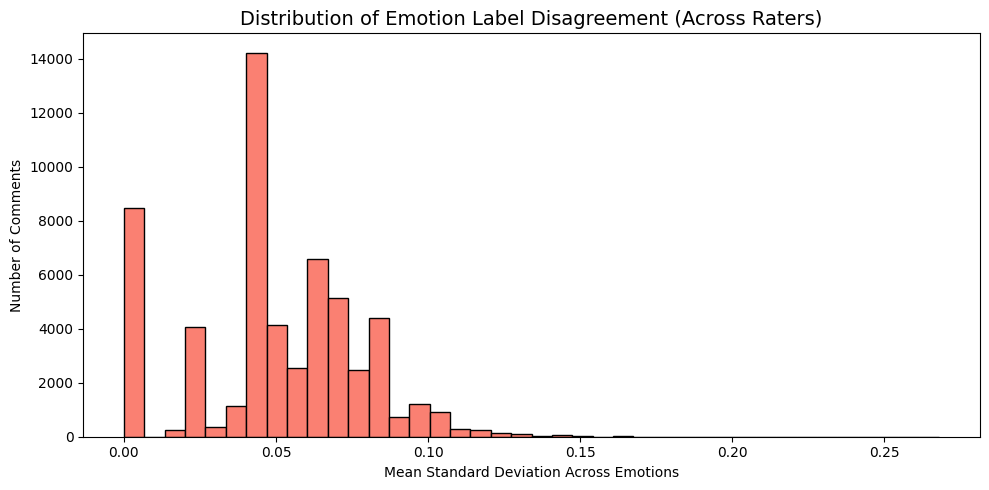

In [60]:
# Mean standard deviation = proxy for inter-rater disagreement

# 1. Group original rater-level data (df_nobias_raw) by comment ID, and compute std dev for emotion scores
df_nobias_raw_std = df_nobias_raw.groupby('id')[emotion_cols].std()

# 2. Compute overall disagreement score (mean std across emotions)
df_nobias_raw_std['disagreement_score'] = df_nobias_raw_std.mean(axis=1)

# 3. Plot histogram of disagreement
plt.figure(figsize=(10, 5))
plt.hist(df_nobias_raw_std['disagreement_score'].dropna(), bins=40, color='salmon', edgecolor='black')
plt.title("Distribution of Emotion Label Disagreement (Across Raters)", fontsize=14)
plt.xlabel("Mean Standard Deviation Across Emotions")
plt.ylabel("Number of Comments")
plt.tight_layout()
plt.show()

In [61]:
# Identify the top 10 disagreed comment IDs
top_disagreed_ids = df_nobias_raw_std.sort_values('disagreement_score', ascending=False).head(10).index

# Filter the original DataFrame to get rows for these comments
df_nobias_raw_top_disagreed = df_nobias_raw[df_nobias_raw['id'].isin(top_disagreed_ids)].copy()

# Define the columns to display
cols_to_display = ['id', 'text', 'rater_id'] + emotion_cols.tolist()

# Display the selected columns for the top disagreed comments, sorted by id
display(df_nobias_raw_top_disagreed[cols_to_display].sort_values(by='id').head(30))

id                                               text  rater_id  \
136456  edd51ul  HAS THE WHOLE WORLD GONE CRAZY‽ AM I THE ONLY ...        27   
91132   edd51ul  HAS THE WHOLE WORLD GONE CRAZY‽ AM I THE ONLY ...        31   
90247   edd51ul  HAS THE WHOLE WORLD GONE CRAZY‽ AM I THE ONLY ...         4   
196716  edelx9y  Two or three anti depressants before I told th...        23   
151880  edelx9y  Two or three anti depressants before I told th...        31   
57418   edelx9y  Two or three anti depressants before I told th...        70   
170612  edgmob1  Welcome to racial integration, where your civi...        19   
117503  edgmob1  Welcome to racial integration, where your civi...        66   
101804  edgmob1  Welcome to racial integration, where your civi...        31   
3439    edgmob1  Welcome to racial integration, where your civi...        27   
40425   edgmob1  Welcome to racial integration, where your civi...        78   
79286   edrjfw8  I hope you’re okay! I’m so sorry that happened...        15   
18964   edrjfw8  I hope you’re okay! I’m so sorry that happened...        31   
30218   edrjfw8  I hope you’re okay! I’m so sorry that happened...        57   
126769  edzetty  At least you should have helped out since you ...         6   
108471  edzetty  At least you should have helped out since you ...        31   
129792  edzetty  At least you should have helped out since you ...        61   
187999  ee2zbyj  I’m so glad I’m not the only one. Since everyt...        26   
161760  ee2zbyj  I’m so glad I’m not the only one. Since everyt...        31   
145509  ee2zbyj  I’m so glad I’m not the only one. Since everyt...        45   
83483   eeldk5y  It happens way more than you think. People are...        31   
170682  eeldk5y  It happens way more than you think. People are...        15   
194991  eeldk5y  It happens way more than you think. People are...        21   
103364  eeldk5y  It happens way more than you think. People are...        19   
133262  eeldk5y  It happens way more than you think. People are...        66   
54430   eeqmqtv  Despite how much the Liberals and NDP apparent...        31   
33790   eeqmqtv  Despite how much the Liberals and NDP apparent...        52   
59355   eeqmqtv  Despite how much the Liberals and NDP apparent...         4   
96219   eeqmqtv  Despite how much the Liberals and NDP apparent...        39   
17592   efg0w0j  They say nature makes man feel small, but I wa...        40   

        admiration  amusement  anger  annoyance  approval  caring  confusion  \
136456           0          0      0          1         0       0          0   
91132            0          1      0          1         0       0          0   
90247            0          0      1          0         0       0          0   
196716           0          0      0          0         0       0          0   
151880           1          0      0          0         1       0          0   
57418            0          0      0          0         0       0          0   
170612           0          0      0          1         0       0          0   
117503           0          0      0          1         0       0          0   
101804           1          0      0          0         1       0          1   
3439             0          0      0          0         0       1          0   
40425            0          0      1          0         0       0          0   
79286            0          0      0          0         0       1          0   
18964            0          0      0          0         0       1          0   
30218            0          0      0          0         0       0          0   
126769           0          0      0          0         0       0          0   
108471           1          0      1          0         0       1          0   
129792           0          0      0          0         0       0          0   
187999           0          0      0          0         0       0          0   
161760      

## Word Clouds for Emotion-Specific Language

FOR WHAT? → Visually profile the top words associated with each emotion.

SO WHAT? → Makes emotion language immediately intuitive, helps non-tech viewers understand the data.

## ! df_emotion_labeled
## ! df_tfidf
## TF-IDF Word Fingerprints per Emotion

FOR WHAT? → Capture emotion-specific vocabulary profiles.
SO WHAT? → Feature engineering, label explanation, or attention cue for models.

In [62]:
# Melt the DataFrame to long form: one emotion per row
df_melted = df_nobias_clean.melt(
    id_vars=['text'],
    value_vars=emotion_cols,  # all emotions
    var_name='emotion',
    value_name='score'
)

# Filter to emotion-labeled rows only (score > 0.5 to keep it confident)
df_emotion_labeled = df_melted[df_melted['score'] > 0.5]
df_emotion_labeled

text     emotion  \
22       I really appreciate you saying that And yes he...  admiration   
31       it's an amazing feeling! I love being happy :))))  admiration   
48       This thread was actually inspired by one of yo...  admiration   
59                                     This is really cute  admiration   
61       Oooh yes, great idea. Too bad there aren't any...  admiration   
...                                                    ...         ...   
1624093  Well that Praying Mantis had some balls. Just ...     neutral   
1624095                           Here's the authors blog.     neutral   
1624104                       Here i am playing Daggerfall     neutral   
1624109  Approaching doesn't work unless you are [NAME]...     neutral   
1624111                              Ok now that was epic!     neutral   

            score  
22       1.000000  
31       0.666667  
48       0.666667  
59       1.000000  
61       1.000000  
...           ...  
1624093  0.666667  
1624095  1.000000  
1624104  0.666667  
1624109  1.000000  
1624111  0.666667  

[45044 rows x 3 columns]

In [63]:
# Group by emotion and join all text
grouped = df_emotion_labeled.groupby('emotion')['text'].apply(lambda texts: ' '.join(texts))

# TF-IDF
vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=3, 
    max_features=100, 
    stop_words='english'
) # quick look

tfidf_matrix = vectorizer.fit_transform(grouped)

# Create DataFrame of words
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), index=grouped.index, columns=vectorizer.get_feature_names_out())
df_tfidf = df_tfidf.sort_index()
df_tfidf.head()

agree   amazing  appreciate   awesome  beautiful   believe  \
emotion                                                                     
admiration  0.014320  0.283837    0.128852  0.361731   0.214499  0.008219   
amusement   0.020685  0.024228    0.006660  0.033298   0.010713  0.021222   
anger       0.003540  0.003189    0.007598  0.000000   0.003667  0.013207   
annoyance   0.031211  0.008034    0.000000  0.004785   0.013855  0.070697   
approval    0.514679  0.018736    0.025106  0.016737   0.008077  0.092129   

                 big      come   comment      cool  ...      wait      want  \
emotion                                             ...                       
admiration  0.039041  0.024466  0.022603  0.127787  ...  0.017020  0.038014   
amusement   0.021222  0.031960  0.061738  0.027853  ...  0.019975  0.059809   
anger       0.013207  0.027348  0.019811  0.007333  ...  0.017092  0.082544   
annoyance   0.054063  0.043057  0.103967  0.013855  ...  0.034446  0.112284   
approval    0.029093  0.052713  0.046064  0.096927  ...  0.022591  0.096977   

               watch      wish      work     world       wow     wrong  \
emotion                                                                  
admiration  0.036167  0.022819  0.090416  0.033743  0.115123  0.009247   
amusement   0.035955  0.025711  0.043946  0.024228  0.027955  0.040515   
anger       0.020511  0.011000  0.030766  0.022326  0.015947  0.036319   
annoyance   0.060280  0.013855  0.068891  0.080343  0.028120  0.066539   
approval    0.045183  0.024232  0.082835  0.046839  0.011710  0.065460   

                yeah       yes  
emotion                         
admiration  0.053424  0.036720  
amusement   0.123476  0.061501  
anger       0.082544  0.057409  
annoyance   0.149712  0.052223  
approval    0.332148  0.337240  

[5 rows x 100 columns]

## WordClouds

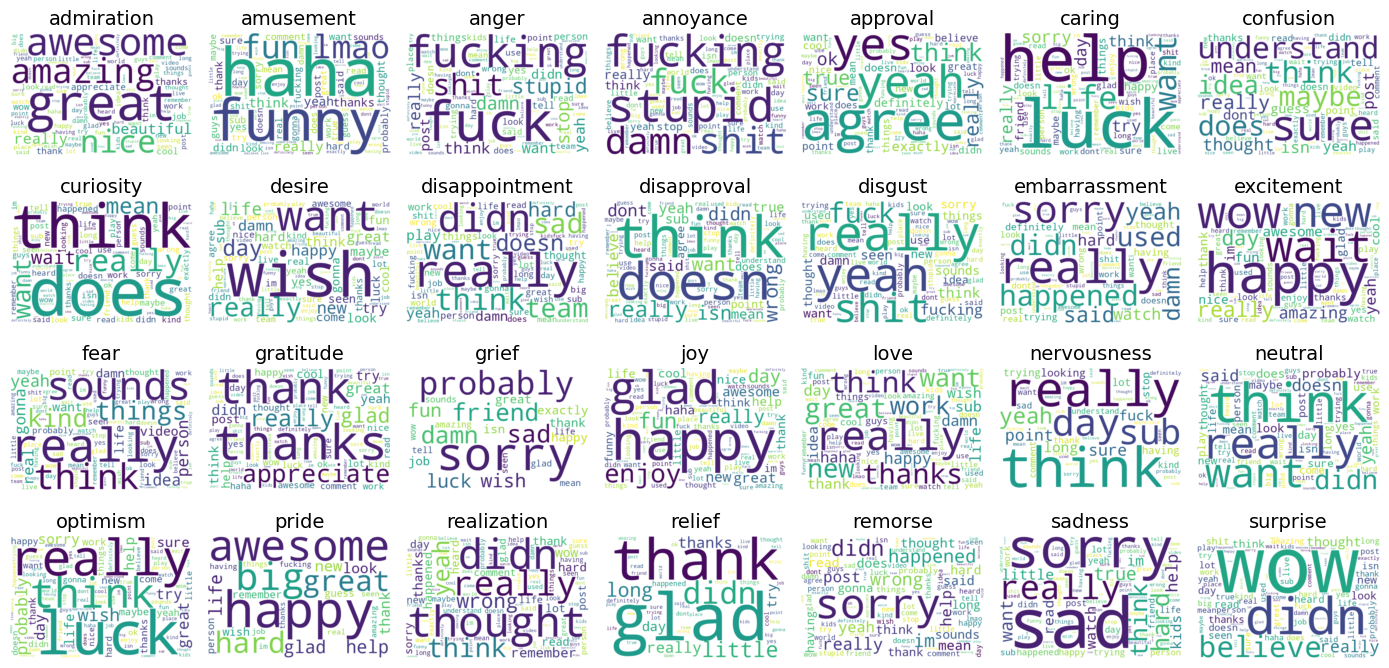

In [64]:
# Define how many emotions to visualize
emotions_to_plot = df_tfidf.index[:28]  # change this to show more

# Plot word clouds
fig, axes = plt.subplots(4, 7, figsize=(14, 7))
axes = axes.flatten()

for i, emotion in enumerate(emotions_to_plot):
    tfidf_row = df_tfidf.loc[emotion]
    wordcloud = WordCloud(width=600, height=400, background_color='white', random_state=42).generate_from_frequencies(tfidf_row)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f"{emotion}", fontsize=14)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Emotion Embedding Space (Word2Vec + t-SNE)

FOR WHAT? → Reduce high-dimensional emotion language vectors to 2D.

SO WHAT? → Maps semantic closeness between emotions — great insight for modeling or psychology analysis.

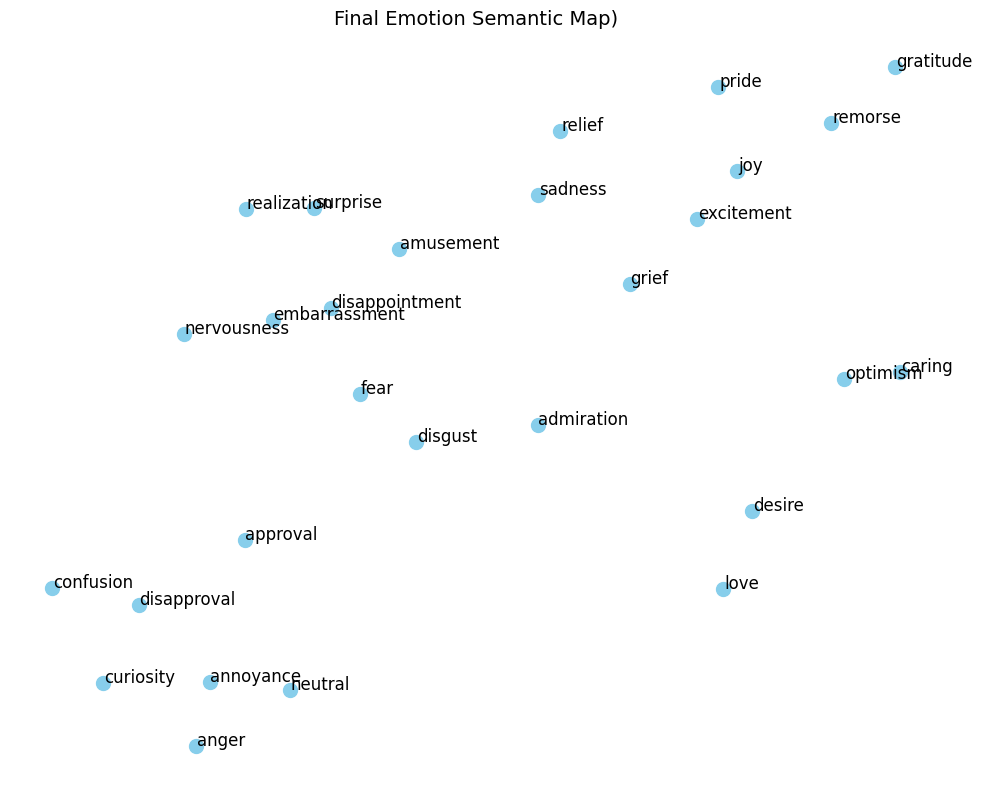

In [65]:
# Group and tokenize
emotion_texts = df_emotion_labeled.groupby('emotion')['text'].apply(lambda texts: ' '.join(texts)).to_dict()
tokenized = {emotion: text.lower().split() for emotion, text in emotion_texts.items()}
sentences_for_w2v = list(tokenized.values())

# Train Word2Vec
w2v_model = Word2Vec(
    sentences=sentences_for_w2v,
    vector_size=100,
    window=5,
    min_count=2,
    workers=2,
    sg=1,
    seed=FINAL_SEED,
    compute_loss=True
)

# Generate vectors
emotion_vectors = {
    emotion: np.mean([w2v_model.wv[t] for t in tokens if t in w2v_model.wv], axis=0)
    for emotion, tokens in tokenized.items()
}

# t-SNE projection
labels = list(emotion_vectors.keys())
X = np.array(list(emotion_vectors.values()))

tsne = TSNE(
    n_components=2,
    perplexity=5,
    learning_rate=200,
    n_iter=2500,
    random_state=FINAL_SEED,
    init='pca',
    method='barnes_hut'
)
X_embedded = tsne.fit_transform(X)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c='skyblue', s=100)

for i, label in enumerate(labels):
    plt.text(X_embedded[i, 0] + 0.5, X_embedded[i, 1], label, fontsize=12)

plt.title("Final Emotion Semantic Map)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()
#plt.savefig("Final_Emotion_Semantic_Map_Run96_Seed16.png")
#plt.close()

## TF-IDF Classifier Training (LogReg)

FOR WHAT? → Quick baseline: can we predict emotion label from text alone?

SO WHAT? → Validates signal richness of the data - key for AI readiness

In [66]:
# Use df_emotion_labeled as-is
# Each row is: text, emotion, score > 0.5

# Step 1: Define X and y (reset index to align with train/test splits)
X_texts = df_emotion_labeled['text'].reset_index(drop=True)
y_emotions = df_emotion_labeled['emotion'].reset_index(drop=True)

# Step 2: TF-IDF vectorization (still aligned)
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2), stop_words='english')
X = vectorizer.fit_transform(X_texts)

# Step 3: Train-test split (everything aligned now)
X_train, X_test, y_train, y_test = train_test_split(X, y_emotions, test_size=0.2, random_state=42)

# Step 4: Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Step 5: Predict
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

    admiration       0.60      0.57      0.58       866
     amusement       0.66      0.72      0.69       496
         anger       0.56      0.34      0.42       308
     annoyance       0.36      0.15      0.21       315
      approval       0.33      0.12      0.18       483
        caring       0.52      0.17      0.25       178
     confusion       0.49      0.16      0.24       221
     curiosity       0.38      0.08      0.13       374
        desire       0.48      0.25      0.33       114
disappointment       0.46      0.11      0.17       171
   disapproval       0.35      0.09      0.14       323
       disgust       0.67      0.33      0.44       126
 embarrassment       0.57      0.20      0.30        40
    excitement       0.50      0.13      0.20       151
          fear       0.68      0.36      0.47       111
     gratitude       0.74      0.83      0.78       624
         grief       0.00      0.00      0.00  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [67]:
# Step 6: Misclassified sample inspection

# Build aligned test set DataFrame
test_texts = X_texts.iloc[y_test.index]  # NOW SAFE — indices are 0-based
test_results = pd.DataFrame({
    'text': test_texts.values,
    'true_label': y_test.values,
    'predicted_label': y_pred
}, index=y_test.index)

# Filter for mismatches
misclassified_df = test_results[test_results['true_label'] != test_results['predicted_label']]

# Show examples
misclassified_df[['text', 'true_label', 'predicted_label']].head()

text   true_label  \
25452  But both lost, whereas moderate Sinema won. It...          joy   
26669  Great cover of my favorite song. I loved watch...         love   
33550                             More like *Fun* Camps!      neutral   
24715      ~~macri gato~~ Also, nice to see Buthan there          joy   
17919  I don’t. I love humanity. Why are you afraid o...  disapproval   

      predicted_label  
25452         neutral  
26669      admiration  
33550       amusement  
24715      admiration  
17919            love

## Emotion Classification — Confusion Matrix Analysis

After training a logistic regression model to predict emotional labels from text,
we evaluate its performance using **confusion matrices**.

These help us understand:

FOR WHAT? → Where the model makes mistakes — which emotions are confused.

SO WHAT? → Guides future decisions:
    - Which labels need better separation
    - Which ones might be too similar (e.g. admiration vs approval)
    - Whether the dataset or model needs refinement

We include:
- Raw counts
- Normalized percentages
- Identification of the **worst-performing emotion class**

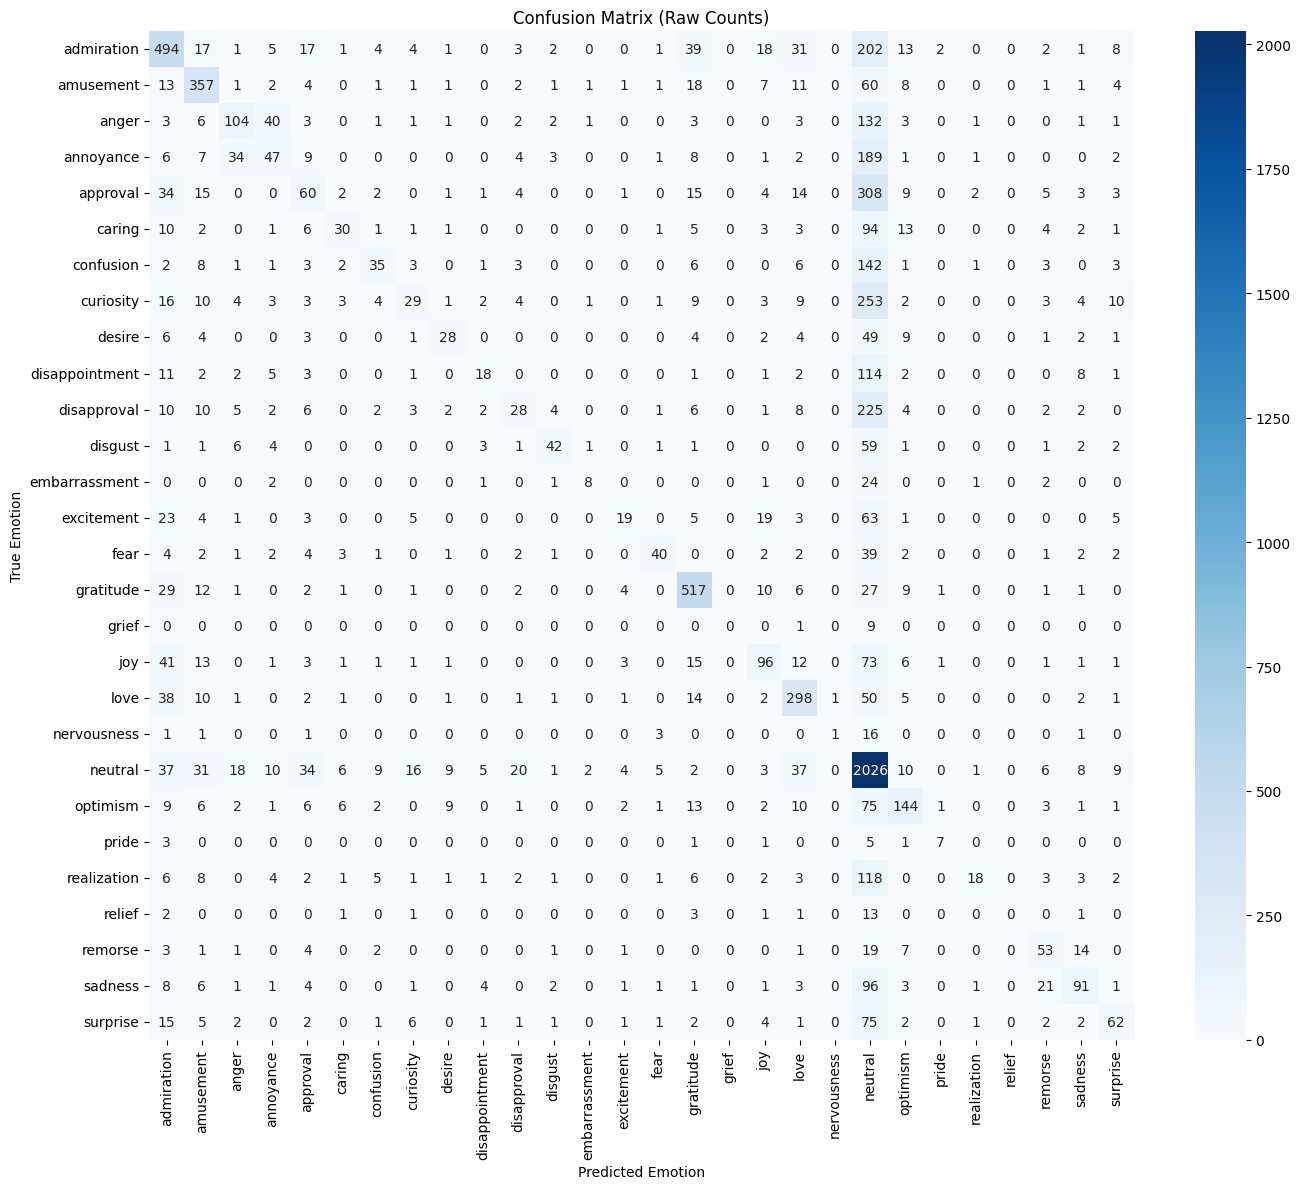

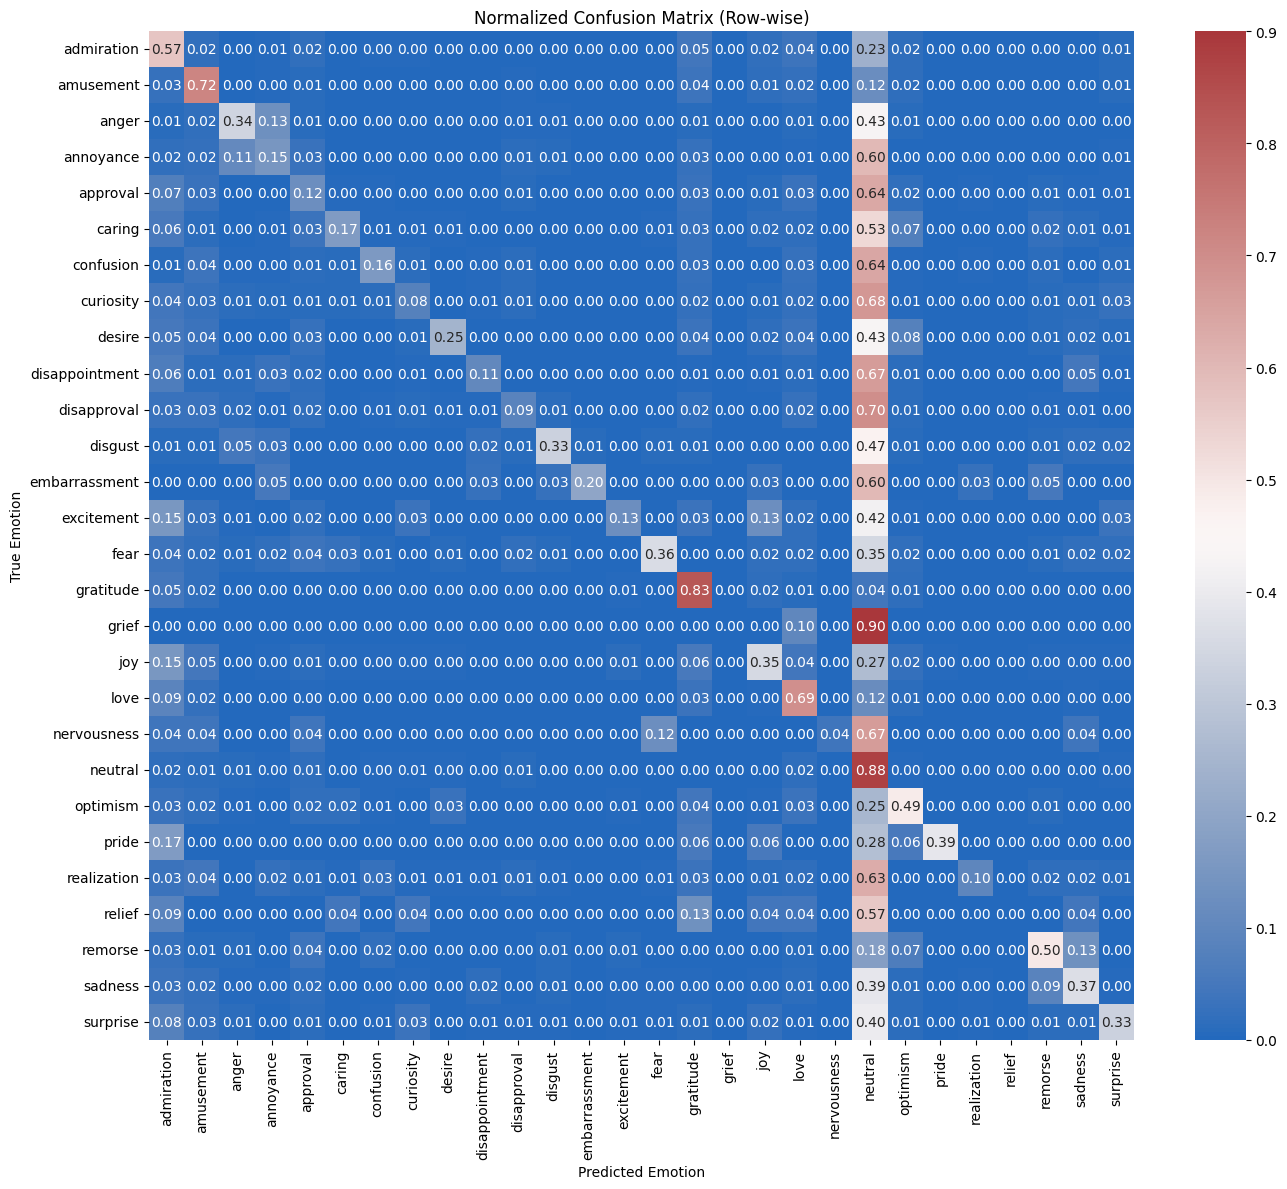

Worst-performing emotion class: grief
Accuracy for grief: 0.00


In [68]:
# Generate raw confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

# Plot raw count matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=clf.classes_,
            yticklabels=clf.classes_,
            cmap="Blues")
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.tight_layout()
plt.show()

# Normalize by row (i.e., per true label)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, annot=True, fmt=".2f",
            xticklabels=clf.classes_,
            yticklabels=clf.classes_,
            cmap="vlag")
plt.title("Normalized Confusion Matrix (Row-wise)")
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
acc_per_class = np.diag(cm) / cm.sum(axis=1)
worst_class_index = np.argmin(acc_per_class)
worst_class = clf.classes_[worst_class_index]
worst_class_score = acc_per_class[worst_class_index]

print(f"Worst-performing emotion class: {worst_class}")
print(f"Accuracy for {worst_class}: {worst_class_score:.2f}")

## 🍰 Appendix 1: Rater Behavior Profiling

We apply:
- Statistical analysis (STD, entropy)
- Semantic alignment (cosine similarity)
- Pairwise comparison (e.g. Rater A vs B)

This builds an audit-grade trust layer for rater quality.

## rater_emotion_means + STD

FOR WHAT? → Measure spread of label usage per rater.

SO WHAT? → Lower std = balanced rater. Higher = label spamming or selective behavior.

In [69]:
rater_emotion_means = df.groupby('rater_id')[emotion_cols].mean()

# Lower std = more balanced use of emotions
rater_std = rater_emotion_means.std(axis=1).sort_values()

# Top most balanced by std
print(rater_std)

rater_id
56    0.025736
11    0.025805
67    0.032381
34    0.033094
63    0.034623
        ...   
47    0.087405
24    0.118540
25    0.118643
33    0.140319
68    0.188982
Length: 82, dtype: float64


## Shannon Entropy per Rater

FOR WHAT? → Statistical measure of how “diverse” a rater’s labeling pattern is.

SO WHAT? → High entropy = uniformly used labels.
Low entropy = potential overuse of a few emotions

In [70]:
# Shannon entropy rewards balanced emotional use — ideal raters have high entropy + low bias.

# Step 1: Get rater emotion means
rater_emotion_means = df.groupby('rater_id')[emotion_cols].mean()

# Step 2: Function to calculate Shannon entropy
def shannon_entropy(probs):
    probs = np.array(probs)
    probs = probs[probs > 0]  # remove zeroes to avoid log error
    return -np.sum(probs * np.log2(probs))

# Step 3: Apply to each rater
rater_entropy = rater_emotion_means.apply(shannon_entropy, axis=1)

# Step 4: Sort from most to least uniform
rater_entropy.sort_values(ascending=False).head()

rater_id
31    9.120235
79    6.341275
9     6.313907
42    5.872128
54    5.502548
dtype: float64

## ! Composite Table - Best Raters - cosine, shannon, std

FOR WHAT? → Summarize all metrics: cosine, entropy, std, range.

SO WHAT? → Allows multidimensional ranking of raters → trust filter

In [71]:
# 1. Clean rater-level dataset (already filtered)
# df_nobias_raw — one row per rater label
# df_nobias_clean — one row per comment (grouped and merged)

# 2. Global emotion frequency profile across the clean comments
global_emotion_profile = df_nobias_clean[emotion_cols].mean()

# 3. Mean emotion profile for each rater (after removing biased raters)
rater_emotion_means = df_nobias_raw.groupby('rater_id')[emotion_cols].mean()

# 4. Cosine similarity to global profile
# How close each rater’s labeling profile is to the global average profile
cosine_scores = rater_emotion_means.apply(
    lambda x: cosine_similarity([x.values], [global_emotion_profile.values])[0][0],
    axis=1
)

# 5. Shannon entropy function
def shannon_entropy(probs):
    probs = np.array(probs)
    probs = probs[probs > 0]  # Avoid log(0)
    return -np.sum(probs * np.log2(probs))

entropy_scores = rater_emotion_means.apply(shannon_entropy, axis=1)

# 6. Standard deviation and range of emotion usage
std_scores = rater_emotion_means.std(axis=1)
range_scores = rater_emotion_means.max(axis=1) - rater_emotion_means.min(axis=1)

# 7. Final summary table
rater_analysis_table = pd.DataFrame({
    'cosine_similarity': cosine_scores,
    'entropy': entropy_scores,
    'std_dev': std_scores,
    'range': range_scores
})
rater_analysis_table.columns = ['Cosine Similarity', 'Entropy', 'Std Dev', 'Range']

print (rater_analysis_table.sort_values(
    by=['Cosine Similarity', 'Entropy', 'Std Dev', 'Range'],
    ascending=[False, False, True, True]
))

"""best_raters = rater_analysis_table[
    (rater_analysis_table['cosine_similarity'] > 0.95) &
    (rater_analysis_table['entropy'] > 4.0) &
    (rater_analysis_table['std_dev'] < 0.07) &
    (rater_analysis_table['range'] < 0.35)
]"""

          Cosine Similarity   Entropy   Std Dev     Range
rater_id                                                 
70                 0.970419  4.715838  0.039380  0.202447
4                  0.968990  4.218146  0.051948  0.252474
39                 0.966552  4.707707  0.058275  0.314694
30                 0.959884  4.115767  0.068712  0.363579
2                  0.958547  4.801964  0.037478  0.201281
...                     ...       ...       ...       ...
79                 0.608150  6.341275  0.058384  0.193046
11                 0.581920  4.509431  0.025805  0.108039
66                 0.581650  5.216094  0.058341  0.208173
65                 0.554581  4.415907  0.053945  0.228571
68                 0.189073 -0.000000  0.188982  1.000000

[79 rows x 4 columns]


"best_raters = rater_analysis_table[\n    (rater_analysis_table['cosine_similarity'] > 0.95) &\n    (rater_analysis_table['entropy'] > 4.0) &\n    (rater_analysis_table['std_dev'] < 0.07) &\n    (rater_analysis_table['range'] < 0.35)\n]"

In [72]:
df[df['rater_id'] == 68]['id'].nunique()
# probably test case user

1

## Spot Check: Rater A vs B (e.g. Rater 24)

FOR WHAT? → Manual inspection of suspicious raters.

SO WHAT? → Builds qualitative understanding of labeling differences.

In [73]:
# Define the IDs of the two raters to check
rater_a_id = 70
rater_b_id = 24

# Create a list of the rater IDs to check
raters_to_check = [rater_a_id, rater_b_id]
df_rcheck = df[df['rater_id'].isin(raters_to_check)]
df_rcheck.groupby('rater_id')['id'].nunique()


rater_id
24    5383
70    5394
Name: id, dtype: int64

In [74]:
df_rcheck.groupby('rater_id')['neutral'].mean()

rater_id
24    0.632361
70    0.204301
Name: neutral, dtype: float64

In [75]:
df_rcheck.groupby('rater_id')[emotion_cols].mean().T

rater_id              24        70
admiration      0.085268  0.097145
amusement       0.023221  0.040601
anger           0.020063  0.058213
annoyance       0.025822  0.047831
approval        0.009660  0.063589
caring          0.002601  0.021691
confusion       0.006316  0.018910
curiosity       0.003715  0.040601
desire          0.000557  0.023730
disappointment  0.009474  0.026511
disapproval     0.003530  0.069707
disgust         0.015605  0.018725
embarrassment   0.004087  0.024472
excitement      0.018205  0.013904
fear            0.008360  0.026326
gratitude       0.083225  0.057286
grief           0.000929  0.001854
joy             0.017091  0.047646
love            0.031209  0.075269
nervousness     0.001486  0.011680
optimism        0.015976  0.027438
pride           0.004830  0.014275
realization     0.002787  0.020393
relief          0.000557  0.007230
remorse         0.000186  0.013348
sadness         0.008360  0.027809
surprise        0.008174  0.037634
neutral         0.632361  0.204301

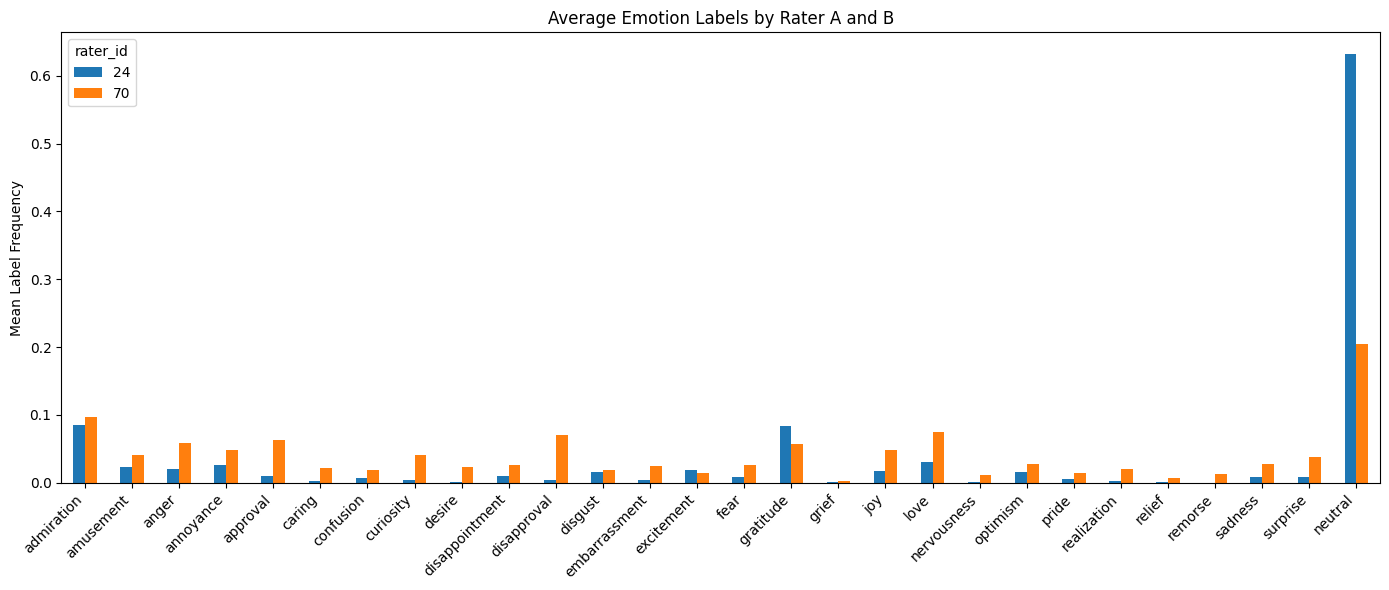

In [76]:
df_rcheck.groupby('rater_id')[emotion_cols].mean().T.plot(kind='bar', figsize=(14, 6))
plt.title("Average Emotion Labels by Rater A and B")
plt.ylabel("Mean Label Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [77]:
df_rcheck.groupby('rater_id')['example_very_unclear'].mean()

rater_id
24    0.000372
70    0.000371
Name: example_very_unclear, dtype: float64

In [78]:
df_rcheck.groupby('rater_id')[emotion_cols].sum().T.sort_values(by=rater_a_id, ascending=False).head(10)

rater_id       24    70
neutral      3404  1102
admiration    459   524
love          168   406
disapproval    19   376
approval       52   343
anger         108   314
gratitude     448   309
annoyance     139   258
joy            92   257
amusement     125   219

In [79]:
rater_a_ids = df[df['rater_id'] == rater_a_id]['id'].unique()
rater_b_ids = df[df['rater_id'] == rater_b_id]['id'].unique()

# Intersection: comments both labeled
shared_ids = set(rater_a_ids) & set(rater_b_ids)
print(f"Shared comments: {len(shared_ids)}")


Shared comments: 302


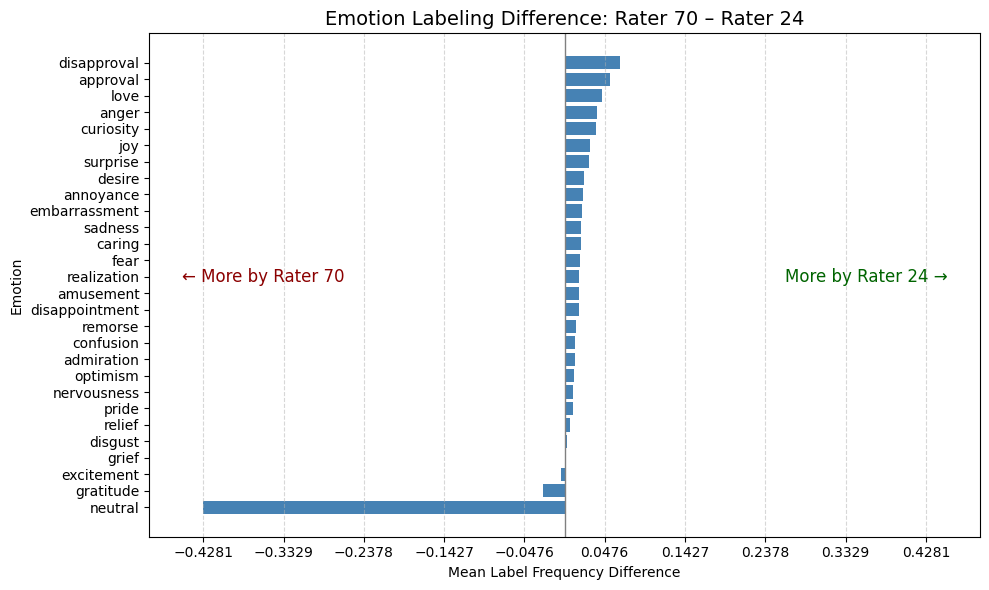

In [80]:
# Compute differences
diffs = df_rcheck.groupby('rater_id')[emotion_cols].mean().diff().iloc[-1]
diffs_sorted = diffs.sort_values()

# Plot setup
plt.figure(figsize=(10, 6))
bars = plt.barh(diffs_sorted.index, diffs_sorted.values, color='steelblue')

# Axis limits and ticks
max_val = abs(diffs_sorted).max()
buffer = max_val * 0.15
plt.xlim(-max_val - buffer, max_val + buffer)
plt.xticks(np.linspace(-max_val, max_val, 10))
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linewidth=1)

# Titles and labels
plt.title(f"Emotion Labeling Difference: Rater {rater_a_id} – Rater {rater_b_id}", fontsize=14)
plt.xlabel("Mean Label Frequency Difference")
plt.ylabel("Emotion")

# Decide who is on which side
left_rater = rater_b_id if diffs_sorted.mean() < 0 else rater_a_id
right_rater = rater_a_id if diffs_sorted.mean() < 0 else rater_b_id

# Annotate
plt.text(-max_val - buffer * 0.4, len(diffs_sorted) / 2, f"← More by Rater {left_rater}",
         fontsize=12, color='darkred', va='center', ha='left')

plt.text(max_val + buffer * 0.4, len(diffs_sorted) / 2, f"More by Rater {right_rater} →",
         fontsize=12, color='darkgreen', va='center', ha='right')

plt.tight_layout()
plt.show()

## Shared Comment Intersection + Pivot

FOR WHAT? → Compare how two raters labeled the same comments.

SO WHAT? → Exposes inter-rater contradictions - supports label auditing or aggregation techniques

In [81]:
df_shared = df[df['id'].isin(shared_ids) & df['rater_id'].isin([rater_b_id, rater_a_id])]

In [82]:
# Identify comments labeled by both raters → examine agreement/disagreement patterns

df_shared_sample = df_shared.sample(100, random_state=1)

df_shared_sample[['id', 'rater_id', 'text'] + list(emotion_cols)]

id  rater_id                                               text  \
124542  eekvv10        70  Right. He didn't even say a word. I feel like ...   
140968  ef5l773        70  All that interesting information and you get 3...   
161335  eep7yha        70  I have the exact same issue and also had my ea...   
197461  edeb7ex        70  I accidentally found it while googling things ...   
156422  eezosy1        70  Eh. People really are judgemental towards "hoe...   
...         ...       ...                                                ...   
185321  edmkm58        70  I can't delete my account, so I'm just gonna e...   
154395  ed1d8jd        24  They're not. They're rolling super hard. And l...   
3479    ef647oj        70  If so, then LN payments are *not* safer than u...   
88673   ef18buu        70                                   Damn this got me   
5993    eepirny        70  The republicans are the military. You are an i...   

        admiration  amusement  anger  annoyance  approval  caring  confusion  \
124542           0          0      0          0         0       0          0   
140968           0          0      0          0         0       0          0   
161335           0          0      0          0         0       0          0   
197461           0          0      0          0         0       0          0   
156422           0          0      1          1         0       0          0   
...            ...        ...    ...        ...       ...     ...        ...   
185321           0          0      0          0         0       0          0   
154395           0          0      0          0         0       0          0   
3479             0          0      0          0         0       0          0   
88673            0          0      0          1         0       0          0   
5993             0          0      0          1         0       0          0   

        ...  love  nervousness  optimism  pride  realization  relief  remorse  \
124542  ...     0            0         0      0            1       0        0   
140968  ...     0            0         0      0            0       0        0   
161335  ...     0            0         0      0            0       0        0   
197461  ...     0            0         0      0            0       0        0   
156422  ...     0            0         0      0            0       0        0   
...     ...   ...          ...       ...    ...          ...     ...      ...   
185321  ...     0            0         0      0            0       0        0   
154395  ...     1            0         0      0            0       0        0   
3479    ...     0            0         0      0            0       0        0   
88673   ...     0            0         0      0            0       0        0   
5993    ...     0            0         0      0            0       0        0   

        sadness  surprise  neutral  
124542        0         0        0  
140968        1         0        0  
161335        0         0        1  
197461        0         0        1  
156422        0         0        0  
...         ...       ...      ...  
185321        0         0        0  
154395        0         0        0  
3479          0         0        0  
88673         0         0        0  
5993          0         0        0  

[100 rows x 31 columns]

In [83]:
pivot = df_shared.pivot_table(index='id', columns='rater_id', values=emotion_cols)
pivot.sample(5, random_state=2).T  # Transposed to make it easier to read

id                       edtky0a  efgfplj  edpz1mo  ed9ehs4  efgjczx
               rater_id                                             
admiration     24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
amusement      24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
anger          24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      1.0      0.0      0.0
annoyance      24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      1.0      0.0      0.0
approval       24            0.0      0.0      0.0      1.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
caring         24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
confusion      24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
curiosity      24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
desire         24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
disappointment 24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
disapproval    24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
disgust        24            0.0      0.0      0.0      0.0      0.0
               70            1.0      0.0      0.0      0.0      0.0
embarrassment  24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
excitement     24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
fear           24            1.0      0.0      0.0      0.0      0.0
               70            1.0      0.0      0.0      0.0      0.0
gratitude      24            0.0      1.0      0.0      0.0      1.0
               70            0.0      0.0      0.0      0.0      1.0
grief          24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
joy            24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
love           24            0.0      0.0      0.0      0.0      0.0
               70            0.0      1.0      0.0      0.0      0.0
nervousness    24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
neutral        24            0.0      0.0      1.0      0.0      0.0
               70            0.0      0.0      0.0      1.0      0.0
optimism       24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
pride          24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
realization    24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
relief         24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
remorse        24            0.0      0.0      0.0      0.0      0.0
               70            0.0      1.0      0.0      0.0      0.0
sadness        24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.0
surprise       24            0.0      0.0      0.0      0.0      0.0
               70            0.0      0.0      0.0      0.0      0.

# BONUS 🍄
## ? The Mystery of Extra 279 ids

### text    → 57732 unique
### id      → 58011 unique

In [84]:
dupe_texts = df[df.duplicated("text", keep=False)]
dupe_counts = dupe_texts.groupby("text")["id"].nunique().reset_index()
dupe_counts = dupe_counts[dupe_counts["id"] > 1].sort_values("id", ascending=False)

# Show top repeated texts
for text in dupe_counts["text"].head(5):
    print("=== TEXT ===")
    print(text)
    print(df[df["text"] == text][["id", "link_id", "rater_id"]])
    print("\n")

=== TEXT ===
Thank you.
             id    link_id  rater_id
9041    edkrvr7  t3_advhxw        20
9101    ed7mh5o  t3_acanp1        18
11235   edarsv4  t3_acrfg5        35
13108   edkrvr7  t3_advhxw        15
14380   eeg2h53  t3_agvlb2         2
18038   edrs8h6  t3_aepd6l         6
27165   edd71rs  t3_acw9g4        33
43478   efe973c  t3_alcu8z        35
44599   ee8stlx  t3_agoek9        76
45782   edarsv4  t3_acrfg5        24
49907   ef3jfzy  t3_akb552        61
53206   ef0u8ds  t3_ajvj26        15
56441   effessg  t3_ald1d7        26
60237   edcgthw  t3_acz69t        76
72565   edcgthw  t3_acz69t        78
77042   edarsv4  t3_acrfg5        70
79754   efh7psd  t3_als994        15
82216   eeg2h53  t3_agvlb2        62
82907   ee8stlx  t3_agoek9        46
83486   edrs8h6  t3_aepd6l        51
84454   efe973c  t3_alcu8z         4
84876   ed7mh5o  t3_acanp1        74
86327   efh7psd  t3_als994        24
88985   effessg  t3_ald1d7        46
91321   eeg2h53  t3_agvlb2        67
101581  edpino

In [85]:
df.groupby('text')['id'].nunique().value_counts().sort_index()

id
1     57559
2       125
3        28
4         8
5         4
6         4
7         1
9         1
11        1
15        1
Name: count, dtype: int64

In [86]:
# Total unique ids among duplicated texts - how many such texts
df_text_id_counts = df.groupby('text')['id'].nunique()
num_dup_ids = df_text_id_counts[df_text_id_counts > 1].sum()
num_dup_texts = (df_text_id_counts > 1).sum()
extra_ids = num_dup_ids - num_dup_texts
print(f"Extra unique IDs due to duplication: {extra_ids}")

Extra unique IDs due to duplication: 279


### Conclusions

**1. Annotation Noise Is Systemic and Detectable**  
Some raters labeled “neutral” on 60%+ of their comments.  
These raters were filtered using a mix of detecting methods.

**2. Emotion Space Is Not Flat**  
Strong co-occurrence patterns (e.g., *joy + love*, *anger + disgust*) and clear emotional “clusters” were found.  
Some emotions (e.g., *grief*) were isolated - both semantically and statistically.

**3. Subreddits Reveal Cultural Emotion Signatures**  
Each subreddit has a distinct emotion profile e.g., *AnimalsBeingBros → Caring*, *CryptoCurrency → Anger*.  
This shows that emotional tone is deeply context-dependent.

**4. Human Labels Contradict Emotional Cues**  
We found “neutral-only” labels on highly expressive comments (e.g. “DUTCHY!!!!!!!!!!”)  
Annotation fatigue or cultural blindspots likely drive these contradictions.

**5. ML Models Mirror the Weaknesses of the Labels**  
A TF-IDF logistic regression model hit 52% accuracy overall - but failed entirely on emotions like *grief*, *relief*, and *nervousness*.  
Confusion patterns matched rater inconsistencies and lack of data.

**6. Word Embeddings Reflect Latent Emotional Neighborhoods**  
Word2Vec + t-SNE projections showed that emotions cluster semantically - validating some label groupings while challenging others.

**7. Rater Quality Can Be Quantified**  
Metrics like **cosine similarity**, **entropy**, and **range** helped rank raters from ideal to toxic.  
This can be used to clean future datasets before training.

**8. Minor Duplication Found**  
We detected 279 more unique IDs than texts - suggesting duplicate rating rows. This should be deduplicated in future preprocessing.

----

**Bottom Line:**  
Emotion-labeled datasets require **not just balance and scale**, but **rater-level diagnostics and contradiction checks**.  
Without these, we risk training emotion AI systems on **distorted, flattened, or false emotional realities.**

